# Convnet Model and Training

This aim of notebook is to define the siamese model that will be used for the Humpback Whale challenge. It will also run the model to trainin it agains our previously generated training and validation dataset and also create the results agains a test dataset.

## 0. Module Imports 

In [1]:
import numpy as np
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Load Training, Validation and Test datasets

In [2]:
pickle_file = '../data/Siamese_dataset.pickle'

with open(pickle_file, 'rb') as f:
    save = pickle.load(f)
    train_X1_dataset = save['train_X1_dataset']
    train_X2_dataset = save['train_X2_dataset']
    train_labels = save['train_labels']
    valid_X1_dataset = save['valid_X1_dataset']
    valid_X2_dataset = save['valid_X2_dataset']
    valid_labels = save['valid_labels']
    del save  # hint to help gc free up memory
    print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
    print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)
    train_labels = np.ones(train_labels.shape,dtype=float) - train_labels
    valid_labels = np.ones(valid_labels.shape,dtype=float) - valid_labels

Training set (31218, 44, 100) (31218, 44, 100) (31218,)
Validation set (5510, 44, 100) (5510, 44, 100) (5510,)


##  2. Declaration of Global Constants
Now we declare all the global constants in hee in orde to have them centralized.
This way we can easyly tune our model.

In [3]:
## Image parameters
NUM_CHANNELS = 1
IMAGE_HEIGHT = train_X1_dataset.shape[1]
IMAGE_WIDHT = train_X1_dataset.shape[2]

#Convnet parameters
BETA1 = 0.0005
BETA2 = 0.0001
PATCH_1 = 14
PATCH_2 = 12
DEPTH_1 = 15
DEPTH_2 = 45
NUM_HIDEN_1 = 1600
NUM_HIDEN_2 = 800
EMBEDDING = 400
NUM_LABELS = 1
MARGIN = 10.0


#Training parameters
BATCH_SIZE = 256
NUM_STEPS = 3001
THRESHOLD = 9.5

## 3. Reformat datasets into a TensorFlow-friendly shape:

- convolutions need the image data formatted as a cube (width by height by #channels)
- labels as float 1-hot encodings.



In [4]:
num_labels = 1

def reformat(dataset1, dataset2, labels):
  dataset1 = dataset1.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  dataset2 = dataset2.reshape(
    (-1, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS)).astype(np.float32)
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset1, dataset2, labels
train_X1_dataset, train_X2_dataset, train_labels = reformat(train_X1_dataset, train_X2_dataset, train_labels)
valid_X1_dataset, valid_X2_dataset, valid_labels = reformat(valid_X1_dataset, valid_X2_dataset, valid_labels)
print('Training set', train_X1_dataset.shape, train_X2_dataset.shape, train_labels.shape)
print('Validation set', valid_X1_dataset.shape, valid_X2_dataset.shape, valid_labels.shape)

Training set (31218, 44, 100, 1) (31218, 44, 100, 1) (31218, 1)
Validation set (5510, 44, 100, 1) (5510, 44, 100, 1) (5510, 1)


## 4. Definition of auxiliar functions

### 4.1. Accuracy computation

In [5]:
def accuracy(distance, labels):
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    aux = distance < (mean_p_distance + mean_n_distance)/2
    equal = np.equal(aux[:] , labels[:, 0])
    great = np.greater(aux[:] , labels[:, 0])
    less = np.less(aux[:] , labels[:, 0])
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / distance.shape[0])
    false_pos = np.sum(great.astype(np.float32))
    false_neg = np.sum(less.astype(np.float32))
    return acc, false_pos, false_neg

def print_means(distance, labels):
    print(distance.shape)
    print(labels.shape)
    positives = np.where(labels[:, 0] > 0)
    negatives = np.where(labels[:, 0] == 0)
    print(positives[0].shape)
    print(negatives[0].shape)
    mean_p_distance = np.mean(distance[positives[0]])
    mean_n_distance = np.mean(distance[negatives[0]])
    
    
    plt.figure(figsize=(10, 4))

    # the histogram of the data
    n, bins, patches = plt.hist(distance[positives[0]], 100, normed=1, facecolor='green', alpha=0.2)
    n, bins, patches = plt.hist(distance[negatives[0]], 100, normed=1, facecolor='red', alpha=0.2)
    
    plt.xlabel('Aspect ratio')
    plt.ylabel('Probability')
    plt.title('Histogram of Aspect Ratios')
    plt.axis([0, 30, 0, 0.5])
    plt.grid(True)
    plt.show()
    
    print('Mean negative distance ' +  str(mean_n_distance) + ' mean positive distance ' + str(mean_p_distance))

## 5. Network declaration
We will use tensorflow

In [12]:

siamese_model = tf.Graph()

with siamese_model.as_default():

  # Input data.
    tf_train_X1_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_X2_dataset = tf.placeholder(\
          tf.float32, shape=(BATCH_SIZE, IMAGE_HEIGHT, IMAGE_WIDHT, NUM_CHANNELS))
    tf_train_labels = tf.placeholder(tf.float32, shape=(BATCH_SIZE, NUM_LABELS))
    tf_valid_X1_dataset = tf.constant(valid_X1_dataset)
    tf_valid_X2_dataset = tf.constant(valid_X2_dataset)
    #tf_test_dataset = tf.constant(test_dataset)
  
    # Variables.
    weights = {
      'layer1': tf.Variable(tf.truncated_normal(\
              [PATCH_1, PATCH_1, NUM_CHANNELS, DEPTH_1], stddev=0.1)),
      'layer2': tf.Variable(tf.truncated_normal(\
              [PATCH_2, PATCH_2, DEPTH_1, DEPTH_2], stddev=0.1)),
      'layer3': tf.Variable(tf.truncated_normal(\
              [12375, NUM_HIDEN_1], stddev=0.1)),
      'layer4': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN_1, NUM_HIDEN_2], stddev=0.1)),
      'layer5': tf.Variable(tf.truncated_normal(\
              [NUM_HIDEN_2, EMBEDDING], stddev=0.1))
      }
    biases = {
        'layer1' : tf.Variable(tf.zeros([DEPTH_1])),
        'layer2' : tf.Variable(tf.constant(1.0, shape=[DEPTH_2])),
        'layer3' : tf.Variable(tf.constant(1.0, shape=[NUM_HIDEN_1])),
        'layer4' : tf.Variable(tf.constant(1.0, shape=[NUM_HIDEN_2])),
        'layer5' : tf.Variable(tf.constant(1.0, shape=[EMBEDDING]))
        }
  
  # Model.
    def model(data):
        conv = tf.nn.conv2d(data, weights['layer1'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer1'])
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        conv = tf.nn.conv2d(pool, weights['layer2'], [1, 1, 1, 1], padding='SAME')
        hidden = tf.nn.relu(conv + biases['layer2'])
        pool = tf.nn.max_pool(hidden, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        shape = pool.get_shape().as_list()
        print(shape)
        reshape = tf.reshape(pool, [shape[0], shape[1] * shape[2] * shape[3]])
        hidden = tf.nn.relu(tf.matmul(reshape, weights['layer3']) + biases['layer3'])
        hidden = tf.matmul(hidden, weights['layer4']) + biases['layer4']
        return tf.matmul(hidden, weights['layer5']) + biases['layer5']
    
    
  # Training computation.
    with tf.variable_scope("siamese") as scope:
        logits1 = model(tf_train_X1_dataset)
        scope.reuse_variables()
        logits2 = model(tf_train_X2_dataset)
        
    with tf.variable_scope("siamese_val") as scope:
        val_logits1 = model(tf_valid_X1_dataset)
        scope.reuse_variables()
        val_logits2 = model(tf_valid_X2_dataset)
        
    def loss(y):
        labels_t = y
        labels_f = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        disperssion = BETA2 * tf.reduce_sum(tf.add(tf.pow(logits1, 2),tf.pow(logits2, 2)), 1)
        eucd2 = tf.pow(tf.subtract(logits1, logits2), 2)
        eucd2 = tf.reduce_sum(eucd2, 1)
        eucd = tf.sqrt(eucd2+1e-6, name="eucd")
        C = tf.constant(MARGIN, name="C")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = tf.multiply(labels_t, eucd2, name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = tf.multiply(labels_f, tf.pow(tf.maximum(tf.subtract(C, eucd), 0), 2), name="Nyi_x_C-eucd_xx_2")
        losses = tf.add(pos, neg, name="losses")
        loss = tf.reduce_mean(losses, name="loss")
        return loss
    
    def loss_paper(y):
        labels_i = y
        labels_g = tf.subtract(1.0, y, name="1-yi")          # labels_ = !labels;
        disperssion = BETA1 * (   tf.nn.l2_loss(weights['layer1'])
                                + tf.nn.l2_loss(weights['layer2'])
                                + tf.nn.l2_loss(weights['layer3'])
                                + tf.nn.l2_loss(weights['layer4'])
                                + tf.nn.l2_loss(weights['layer5']) )
        disperssion = disperssion + BETA2 * tf.reduce_sum(tf.add(tf.pow(logits1, 2),tf.pow(logits2, 2)), 1)
        ew2 = tf.pow(tf.subtract(logits1, logits2), 2)
        ew2 = tf.reduce_sum(ew2, 1)
        ew = tf.sqrt(ew2+1e-6, name="ew")
        Q = tf.constant(MARGIN, name="Q")
        # yi*||CNN(p1i)-CNN(p2i)||^2 + (1-yi)*max(0, C-||CNN(p1i)-CNN(p2i)||^2)
        pos = labels_g * ew2 * 2 / Q
        # neg = tf.multiply(labels_f, tf.subtract(0.0,eucd2), name="yi_x_eucd2")
        # neg = tf.multiply(labels_f, tf.maximum(0.0, tf.subtract(C,eucd2)), name="Nyi_x_C-eucd_xx_2")
        neg = labels_i *2 * Q * tf.exp( - 2.77 * ew / Q) 
        losses = tf.add(pos, neg, name="losses")
        losses = tf.add(losses, disperssion)
        loss = tf.reduce_sum(losses, name="loss")
        return loss
    
        
    loss = loss_paper(tf_train_labels)
    
  # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)
  
  
  # Predictions for the training, validation, and test data.
    train_prediction = tf.reduce_sum(tf.pow(tf.subtract(logits1, logits2), 2),1)
    valid_prediction = tf.reduce_sum(tf.pow(tf.subtract(val_logits1, val_logits2), 2),1)
    #test_prediction = tf.nn.softmax(model(tf_test_dataset))

    #num = tf.reduce_sum(logits1 * logits2, axis = 1)
    #print(num.shape)
    #den = tf.sqrt(tf.reduce_sum(tf.pow(logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(logits2, 2),1))
    #train_prediction = num/den
    #num = tf.reduce_sum(val_logits1 * val_logits2, axis = 1)
    #den = tf.sqrt(tf.reduce_sum(tf.pow(val_logits1, 2),1)) * tf.sqrt(tf.reduce_sum(tf.pow(val_logits2, 2),1))
    #valid_prediction = num/den
    embedding1 = val_logits1
    embedding2 = val_logits2

[256, 11, 25, 45]
[256, 11, 25, 45]
[5510, 11, 25, 45]
[5510, 11, 25, 45]


## 6. Model training

Initialized
Minibatch loss at step 0 4077820672.0
Minibatch accuracy: 71.09375 false positives: 46.0 false negatives: 28.0
Validation accuracy: 68.6388384755 false positives: 1072.0 false negatives: 656.0
(5510,)
(5510, 1)
(2582,)
(2928,)


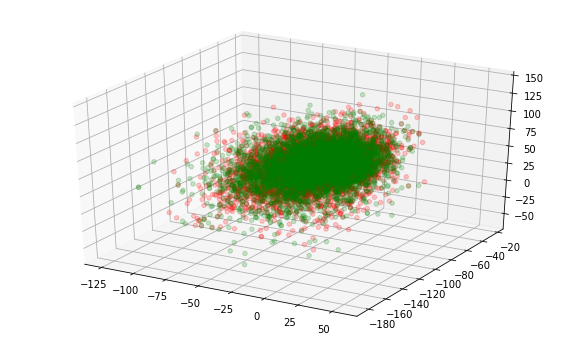

Mean negative distance 373272.0 mean positive distance 234716.0
Minibatch loss at step 50 26382528.0
Minibatch accuracy: 59.765625 false positives: 67.0 false negatives: 36.0
Validation accuracy: 54.7549909256 false positives: 1464.0 false negatives: 1029.0
(5510,)
(5510, 1)
(2582,)
(2928,)


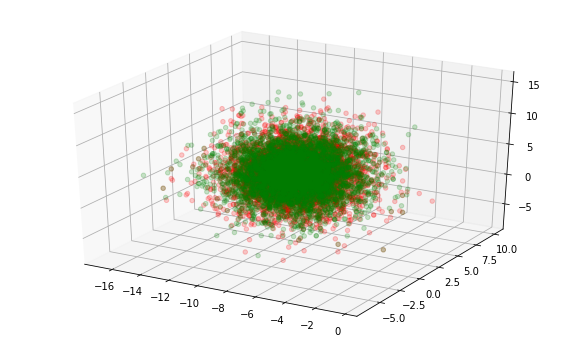

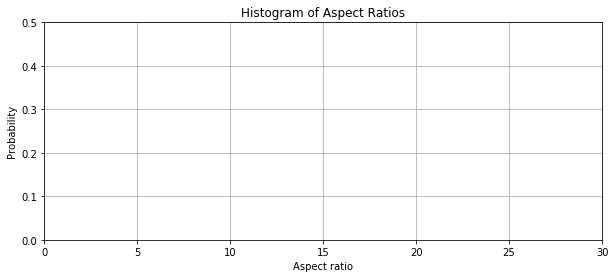

Mean negative distance 3566.78 mean positive distance 3234.2
Minibatch loss at step 100 12257364.0
Minibatch accuracy: 56.640625 false positives: 61.0 false negatives: 50.0
Validation accuracy: 54.0834845735 false positives: 1493.0 false negatives: 1037.0
(5510,)
(5510, 1)
(2582,)
(2928,)


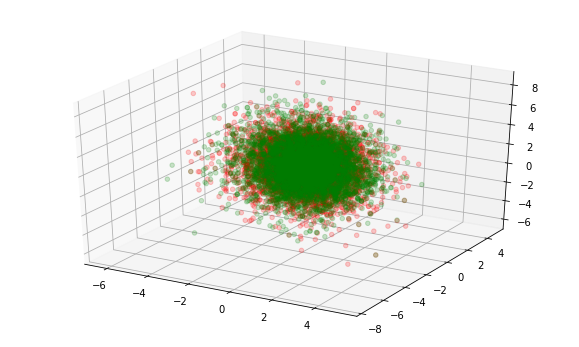

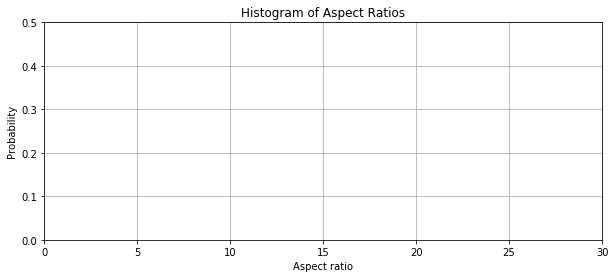

Mean negative distance 1498.9 mean positive distance 1384.35
Minibatch loss at step 150 8988529.0
Minibatch accuracy: 50.78125 false positives: 80.0 false negatives: 46.0
Validation accuracy: 53.3756805808 false positives: 1512.0 false negatives: 1057.0
(5510,)
(5510, 1)
(2582,)
(2928,)


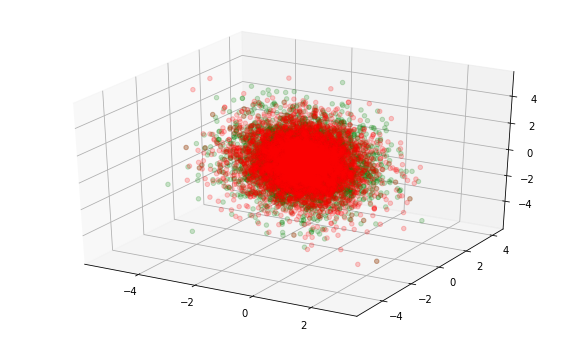

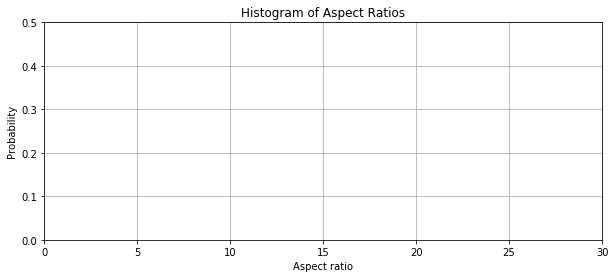

Mean negative distance 850.207 mean positive distance 792.02
Minibatch loss at step 200 6005964.0
Minibatch accuracy: 49.21875 false positives: 77.0 false negatives: 53.0
Validation accuracy: 53.2486388385 false positives: 1521.0 false negatives: 1055.0
(5510,)
(5510, 1)
(2582,)
(2928,)


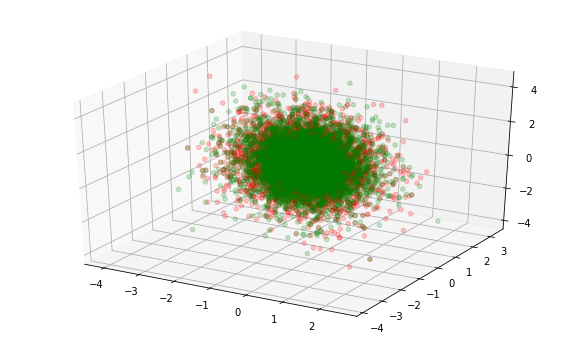

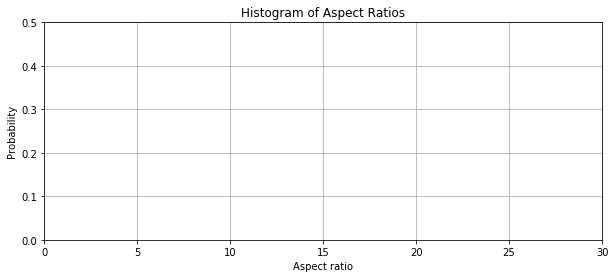

Mean negative distance 520.816 mean positive distance 486.685
Minibatch loss at step 250 4609858.0
Minibatch accuracy: 55.078125 false positives: 68.0 false negatives: 47.0
Validation accuracy: 53.1215970962 false positives: 1533.0 false negatives: 1050.0
(5510,)
(5510, 1)
(2582,)
(2928,)


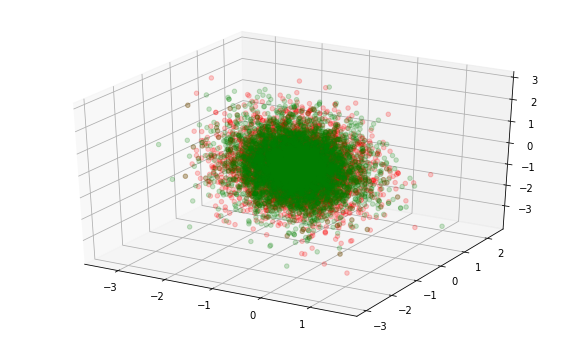

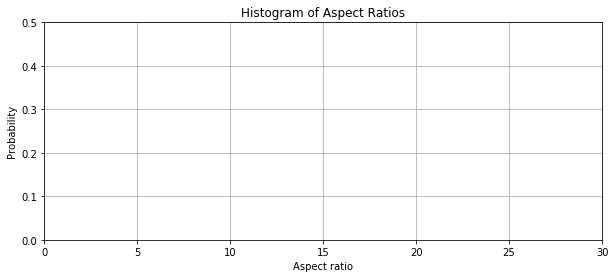

Mean negative distance 322.877 mean positive distance 301.509
Minibatch loss at step 300 3944126.0
Minibatch accuracy: 50.390625 false positives: 75.0 false negatives: 52.0
Validation accuracy: 53.1215970962 false positives: 1516.0 false negatives: 1067.0
(5510,)
(5510, 1)
(2582,)
(2928,)


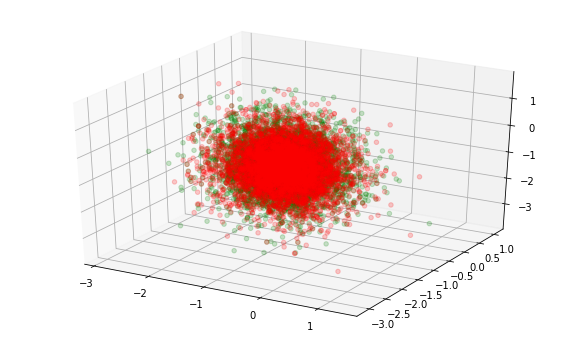

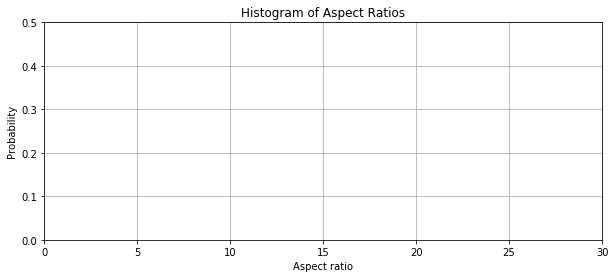

Mean negative distance 209.12 mean positive distance 195.303
Minibatch loss at step 350 3436249.5
Minibatch accuracy: 57.421875 false positives: 62.0 false negatives: 47.0
Validation accuracy: 52.667876588 false positives: 1543.0 false negatives: 1065.0
(5510,)
(5510, 1)
(2582,)
(2928,)


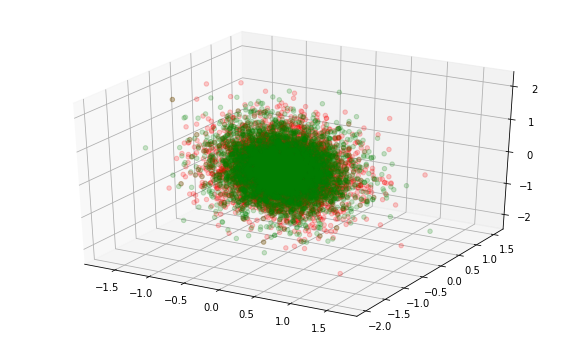

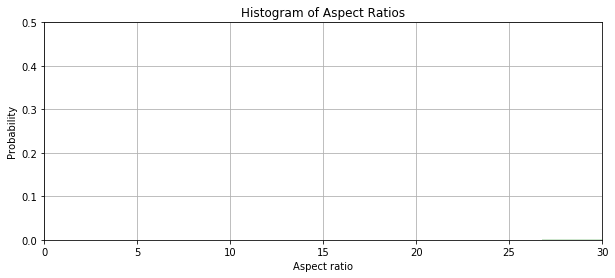

Mean negative distance 139.713 mean positive distance 130.431
Minibatch loss at step 400 3134317.5
Minibatch accuracy: 53.515625 false positives: 66.0 false negatives: 53.0
Validation accuracy: 52.77676951 false positives: 1547.0 false negatives: 1055.0
(5510,)
(5510, 1)
(2582,)
(2928,)


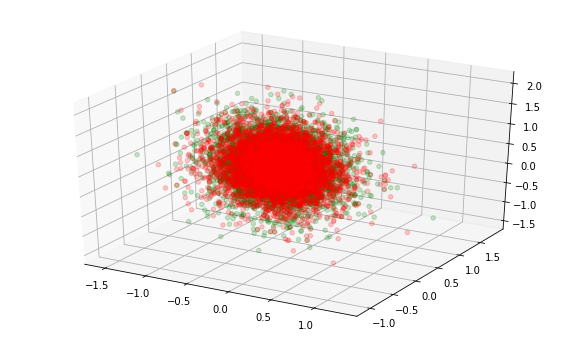

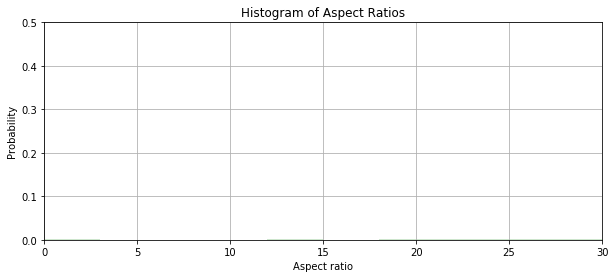

Mean negative distance 95.8035 mean positive distance 89.3096
Minibatch loss at step 450 2964393.25
Minibatch accuracy: 55.46875 false positives: 64.0 false negatives: 50.0
Validation accuracy: 53.1034482759 false positives: 1538.0 false negatives: 1046.0
(5510,)
(5510, 1)
(2582,)
(2928,)


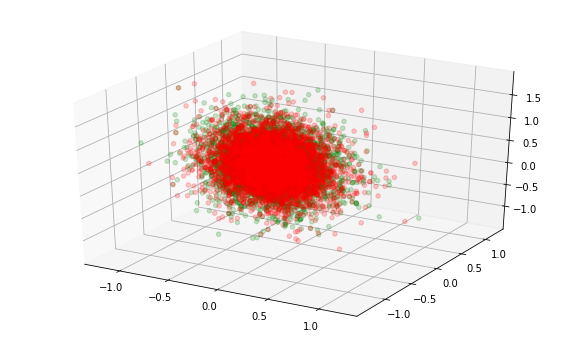

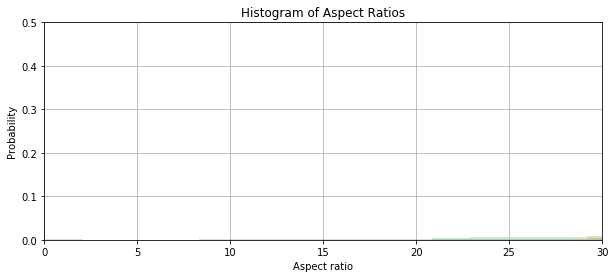

Mean negative distance 68.4757 mean positive distance 63.7019
Minibatch loss at step 500 2893883.0
Minibatch accuracy: 57.421875 false positives: 62.0 false negatives: 47.0
Validation accuracy: 53.0671506352 false positives: 1541.0 false negatives: 1045.0
(5510,)
(5510, 1)
(2582,)
(2928,)


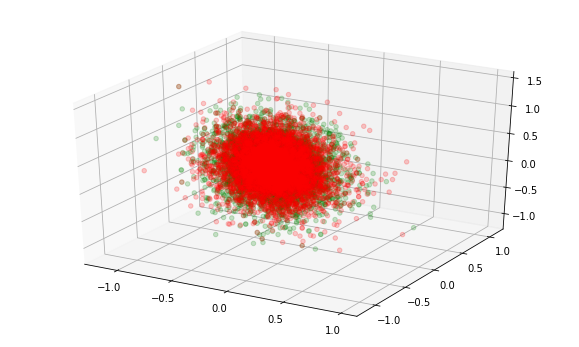

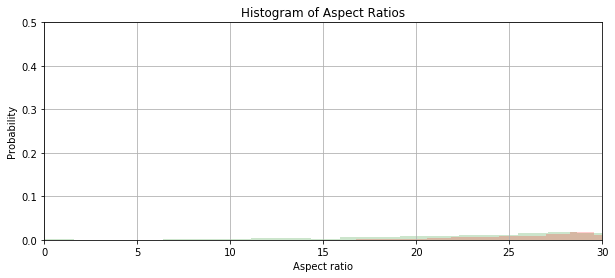

Mean negative distance 50.9702 mean positive distance 47.3186
Minibatch loss at step 550 2847979.5
Minibatch accuracy: 50.390625 false positives: 70.0 false negatives: 57.0
Validation accuracy: 53.6842105263 false positives: 1518.0 false negatives: 1034.0
(5510,)
(5510, 1)
(2582,)
(2928,)


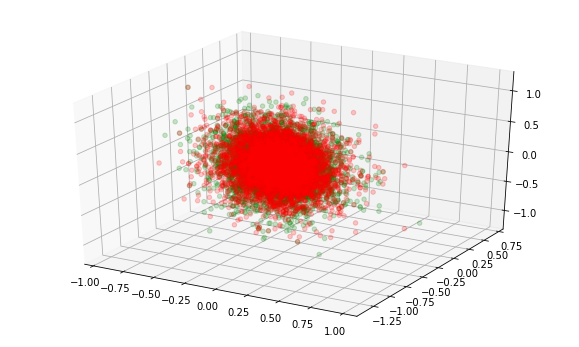

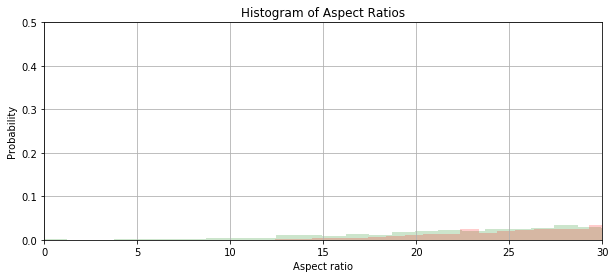

Mean negative distance 40.0587 mean positive distance 36.9649
Minibatch loss at step 600 2823753.0
Minibatch accuracy: 57.03125 false positives: 65.0 false negatives: 45.0
Validation accuracy: 54.3557168784 false positives: 1485.0 false negatives: 1030.0
(5510,)
(5510, 1)
(2582,)
(2928,)


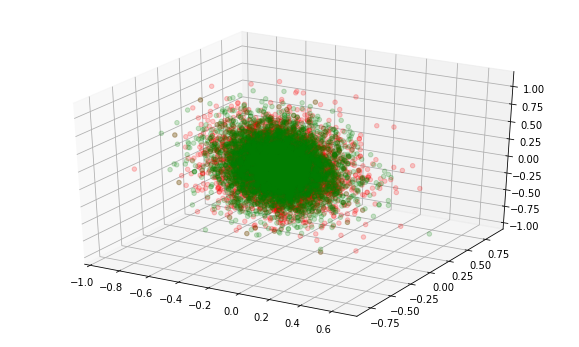

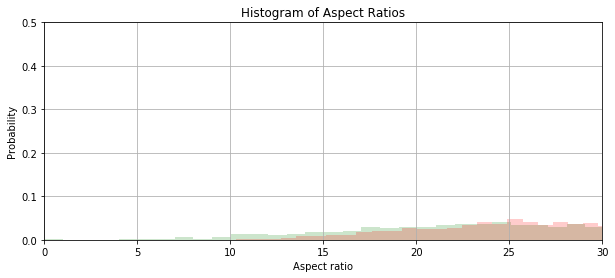

Mean negative distance 32.6964 mean positive distance 30.0656
Minibatch loss at step 650 2803234.0
Minibatch accuracy: 47.65625 false positives: 79.0 false negatives: 55.0
Validation accuracy: 53.4664246824 false positives: 1523.0 false negatives: 1041.0
(5510,)
(5510, 1)
(2582,)
(2928,)


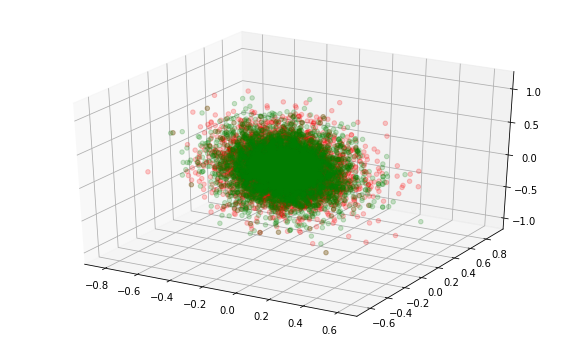

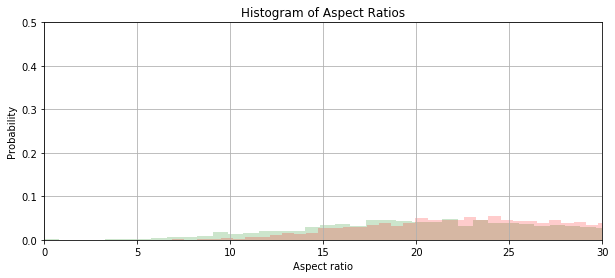

Mean negative distance 27.3656 mean positive distance 25.3677
Minibatch loss at step 700 2786772.0
Minibatch accuracy: 52.734375 false positives: 77.0 false negatives: 44.0
Validation accuracy: 53.5934664247 false positives: 1521.0 false negatives: 1036.0
(5510,)
(5510, 1)
(2582,)
(2928,)


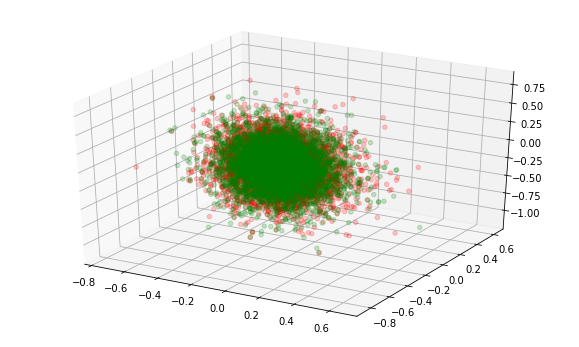

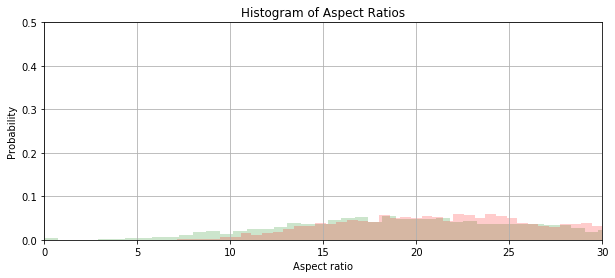

Mean negative distance 24.2293 mean positive distance 22.4349
Minibatch loss at step 750 2788949.5
Minibatch accuracy: 53.515625 false positives: 70.0 false negatives: 49.0
Validation accuracy: 53.666061706 false positives: 1519.0 false negatives: 1034.0
(5510,)
(5510, 1)
(2582,)
(2928,)


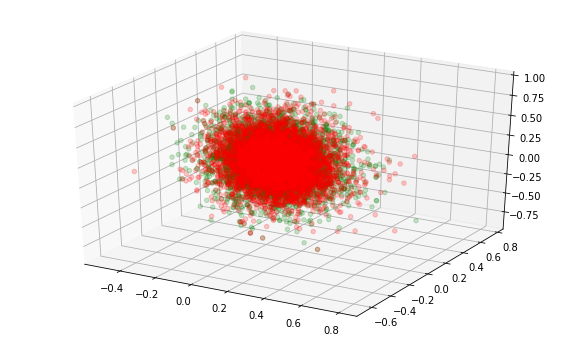

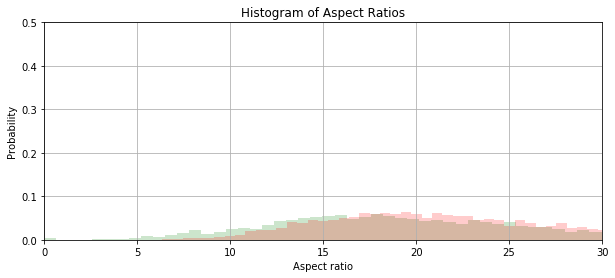

Mean negative distance 22.333 mean positive distance 20.6308
Minibatch loss at step 800 2783635.0
Minibatch accuracy: 56.640625 false positives: 62.0 false negatives: 49.0
Validation accuracy: 54.500907441 false positives: 1476.0 false negatives: 1031.0
(5510,)
(5510, 1)
(2582,)
(2928,)


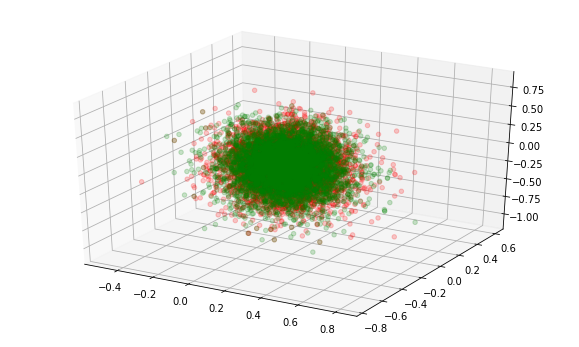

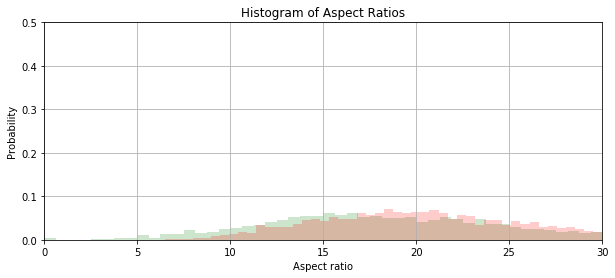

Mean negative distance 21.7799 mean positive distance 19.7165
Minibatch loss at step 850 2768343.25
Minibatch accuracy: 57.421875 false positives: 71.0 false negatives: 38.0
Validation accuracy: 54.2649727768 false positives: 1494.0 false negatives: 1026.0
(5510,)
(5510, 1)
(2582,)
(2928,)


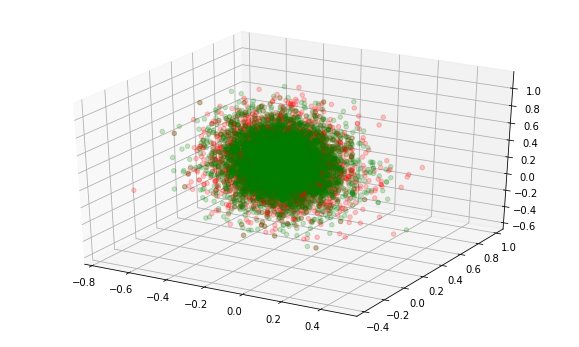

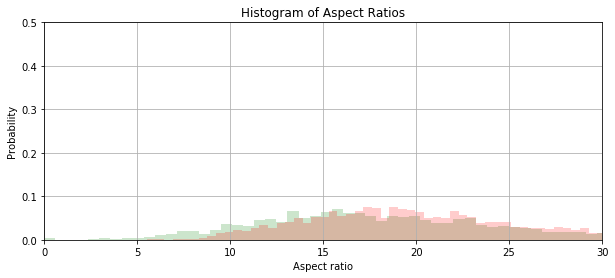

Mean negative distance 20.696 mean positive distance 18.8734
Minibatch loss at step 900 2766729.5
Minibatch accuracy: 59.765625 false positives: 63.0 false negatives: 40.0
Validation accuracy: 56.3702359347 false positives: 1412.0 false negatives: 992.0
(5510,)
(5510, 1)
(2582,)
(2928,)


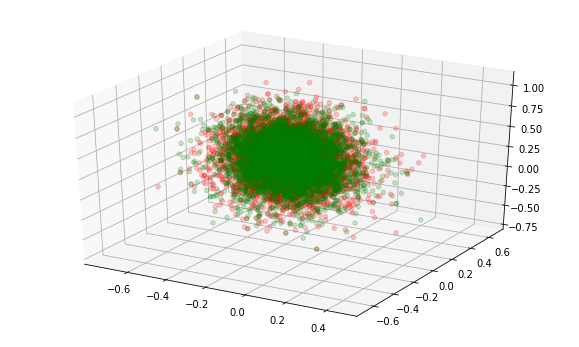

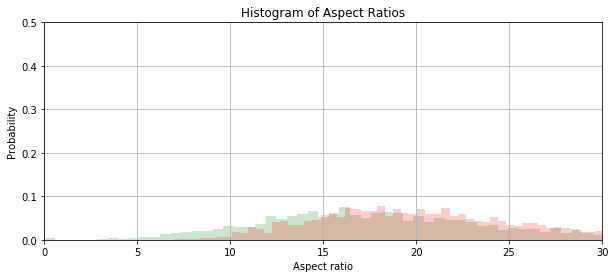

Mean negative distance 21.0297 mean positive distance 18.7395
Minibatch loss at step 950 2762854.5
Minibatch accuracy: 51.171875 false positives: 71.0 false negatives: 54.0
Validation accuracy: 55.5172413793 false positives: 1446.0 false negatives: 1005.0
(5510,)
(5510, 1)
(2582,)
(2928,)


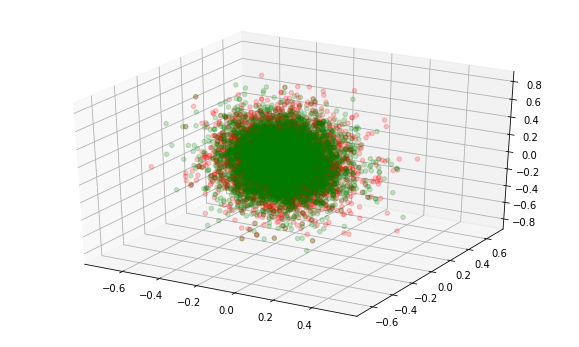

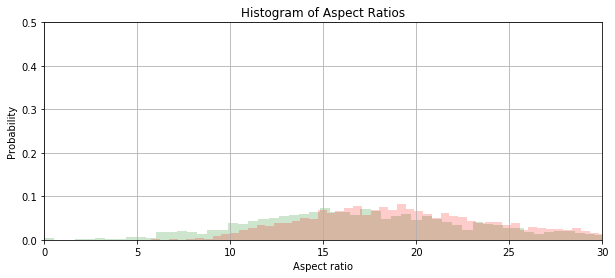

Mean negative distance 20.2877 mean positive distance 18.2068
Minibatch loss at step 1000 2769387.0
Minibatch accuracy: 60.9375 false positives: 50.0 false negatives: 50.0
Validation accuracy: 58.058076225 false positives: 1368.0 false negatives: 943.0
(5510,)
(5510, 1)
(2582,)
(2928,)


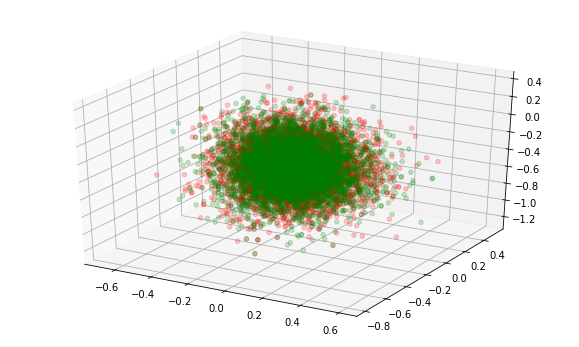

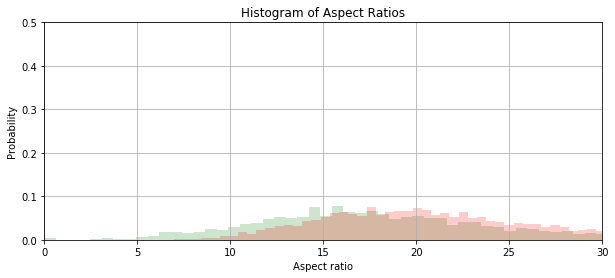

Mean negative distance 21.5319 mean positive distance 18.514
Minibatch loss at step 1050 2759870.75
Minibatch accuracy: 55.078125 false positives: 64.0 false negatives: 51.0
Validation accuracy: 56.2250453721 false positives: 1413.0 false negatives: 999.0
(5510,)
(5510, 1)
(2582,)
(2928,)


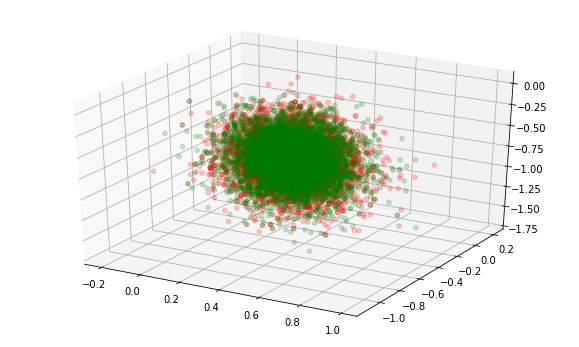

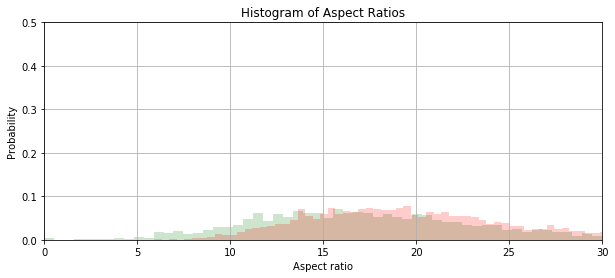

Mean negative distance 20.2504 mean positive distance 17.9599
Minibatch loss at step 1100 2735401.5
Minibatch accuracy: 59.375 false positives: 66.0 false negatives: 38.0
Validation accuracy: 55.7168784029 false positives: 1451.0 false negatives: 989.0
(5510,)
(5510, 1)
(2582,)
(2928,)


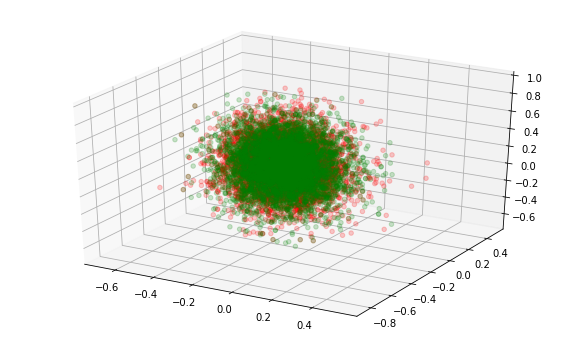

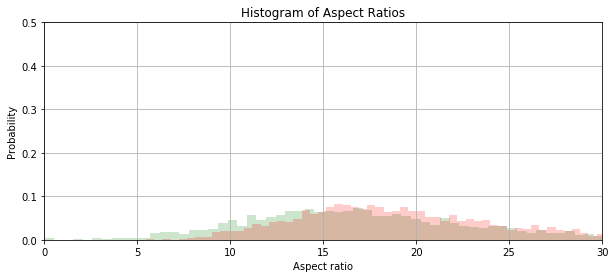

Mean negative distance 19.4542 mean positive distance 17.4454
Minibatch loss at step 1150 2743053.5
Minibatch accuracy: 60.15625 false positives: 58.0 false negatives: 44.0
Validation accuracy: 55.9528130672 false positives: 1443.0 false negatives: 984.0
(5510,)
(5510, 1)
(2582,)
(2928,)


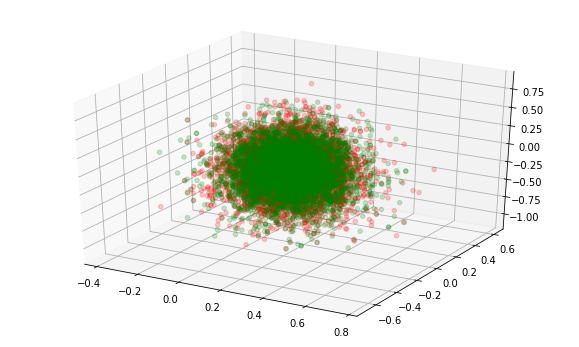

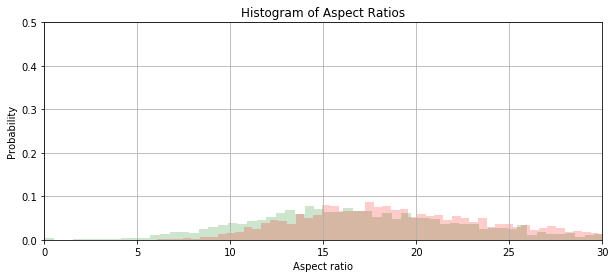

Mean negative distance 19.7727 mean positive distance 17.5729
Minibatch loss at step 1200 2749580.75
Minibatch accuracy: 63.671875 false positives: 48.0 false negatives: 45.0
Validation accuracy: 58.8203266788 false positives: 1344.0 false negatives: 925.0
(5510,)
(5510, 1)
(2582,)
(2928,)


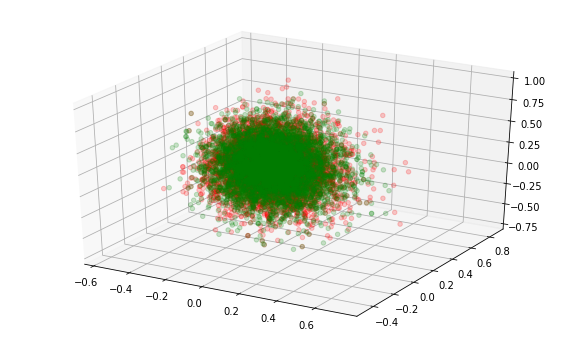

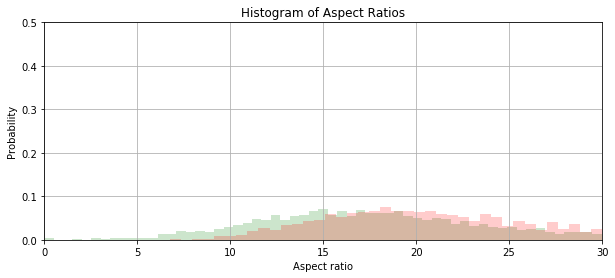

Mean negative distance 21.4514 mean positive distance 18.2169
Minibatch loss at step 1250 2744367.0
Minibatch accuracy: 55.46875 false positives: 55.0 false negatives: 59.0
Validation accuracy: 57.5317604356 false positives: 1384.0 false negatives: 956.0
(5510,)
(5510, 1)
(2582,)
(2928,)


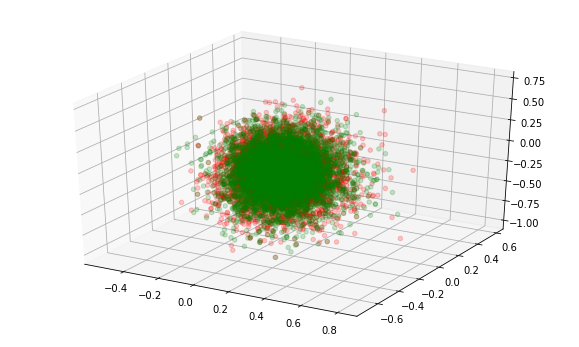

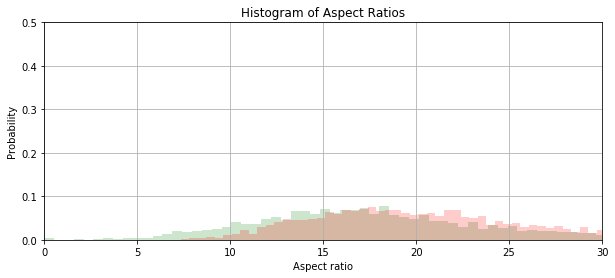

Mean negative distance 20.5708 mean positive distance 17.968
Minibatch loss at step 1300 2729936.25
Minibatch accuracy: 61.328125 false positives: 57.0 false negatives: 42.0
Validation accuracy: 57.277676951 false positives: 1390.0 false negatives: 964.0
(5510,)
(5510, 1)
(2582,)
(2928,)


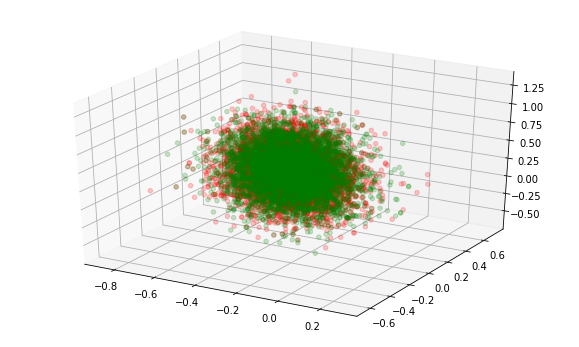

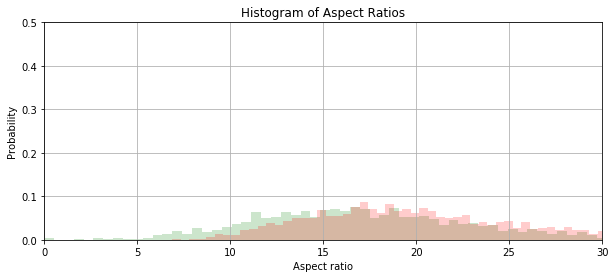

Mean negative distance 20.3156 mean positive distance 17.6585
Minibatch loss at step 1350 2723999.25
Minibatch accuracy: 56.25 false positives: 62.0 false negatives: 50.0
Validation accuracy: 57.2595281307 false positives: 1402.0 false negatives: 953.0
(5510,)
(5510, 1)
(2582,)
(2928,)


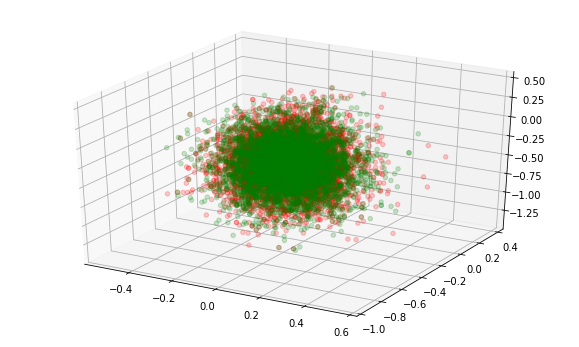

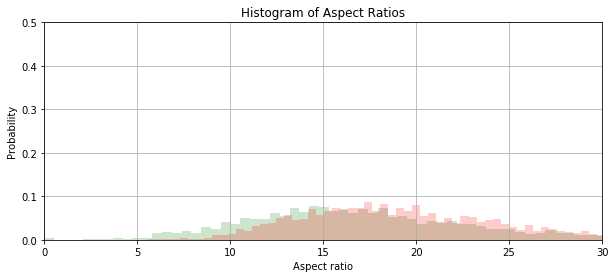

Mean negative distance 19.6397 mean positive distance 17.2187
Minibatch loss at step 1400 2720302.5
Minibatch accuracy: 57.8125 false positives: 61.0 false negatives: 47.0
Validation accuracy: 56.4791288566 false positives: 1399.0 false negatives: 999.0
(5510,)
(5510, 1)
(2582,)
(2928,)


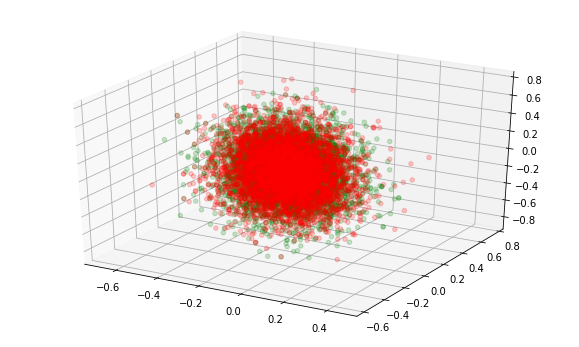

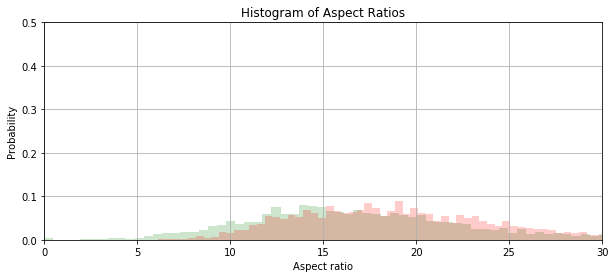

Mean negative distance 19.396 mean positive distance 17.1834
Minibatch loss at step 1450 2719079.25
Minibatch accuracy: 53.90625 false positives: 62.0 false negatives: 56.0
Validation accuracy: 56.8239564428 false positives: 1397.0 false negatives: 982.0
(5510,)
(5510, 1)
(2582,)
(2928,)


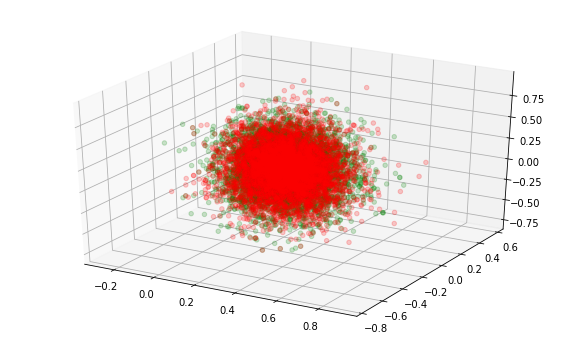

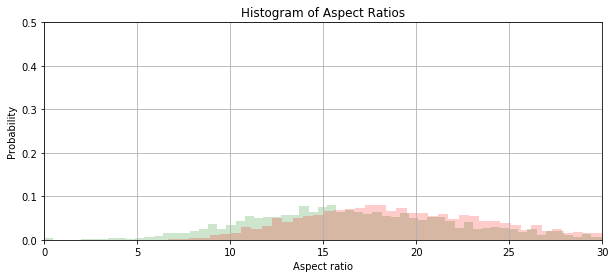

Mean negative distance 19.8213 mean positive distance 17.3763
Minibatch loss at step 1500 2710771.25
Minibatch accuracy: 60.15625 false positives: 62.0 false negatives: 40.0
Validation accuracy: 56.5335753176 false positives: 1395.0 false negatives: 1000.0
(5510,)
(5510, 1)
(2582,)
(2928,)


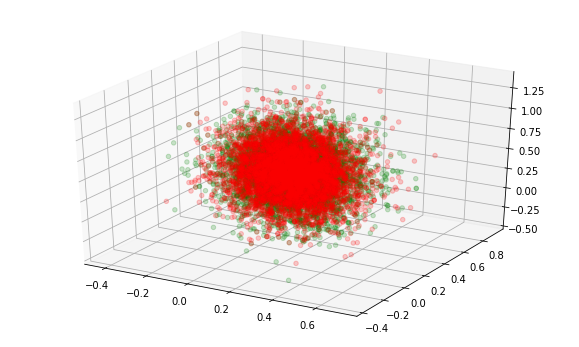

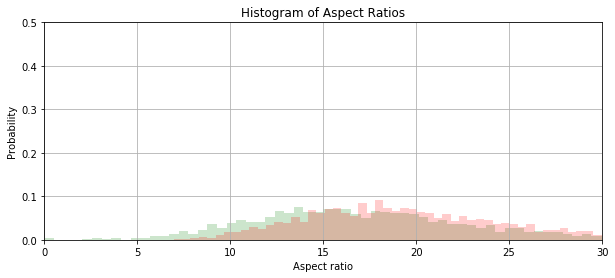

Mean negative distance 19.889 mean positive distance 17.5221
Minibatch loss at step 1550 2712838.75
Minibatch accuracy: 57.8125 false positives: 57.0 false negatives: 51.0
Validation accuracy: 57.7676950998 false positives: 1379.0 false negatives: 948.0
(5510,)
(5510, 1)
(2582,)
(2928,)


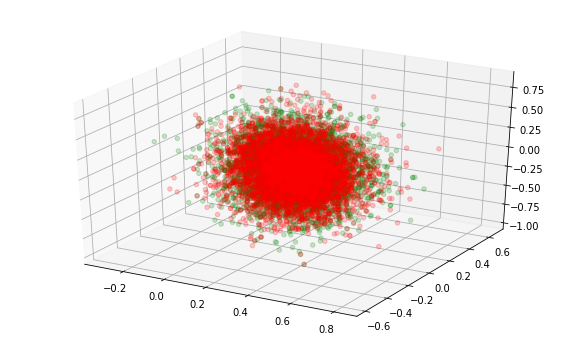

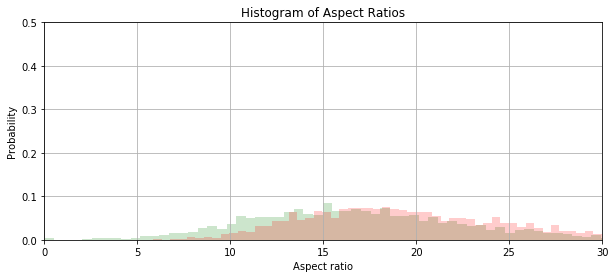

Mean negative distance 20.1065 mean positive distance 17.2866
Minibatch loss at step 1600 2721353.5
Minibatch accuracy: 59.375 false positives: 49.0 false negatives: 55.0
Validation accuracy: 58.6751361162 false positives: 1364.0 false negatives: 913.0
(5510,)
(5510, 1)
(2582,)
(2928,)


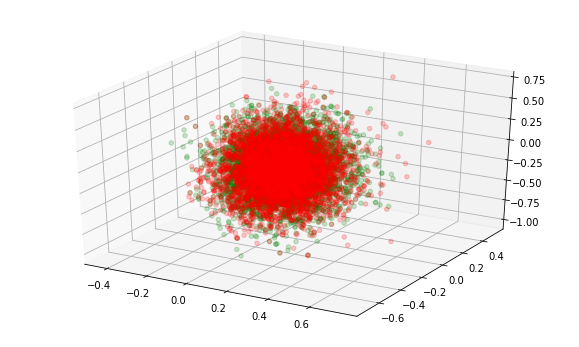

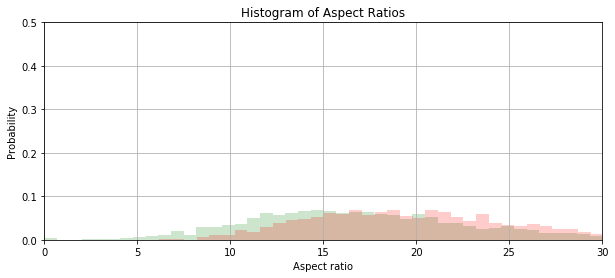

Mean negative distance 21.0741 mean positive distance 17.5307
Minibatch loss at step 1650 2700265.0
Minibatch accuracy: 62.5 false positives: 50.0 false negatives: 46.0
Validation accuracy: 58.3847549909 false positives: 1352.0 false negatives: 941.0
(5510,)
(5510, 1)
(2582,)
(2928,)


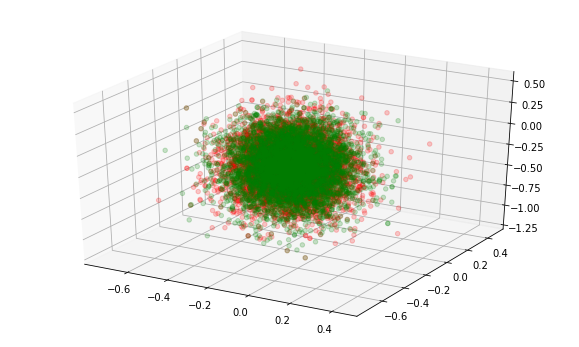

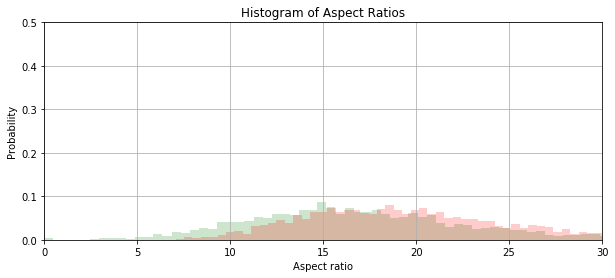

Mean negative distance 20.0186 mean positive distance 17.1991
Minibatch loss at step 1700 2700421.0
Minibatch accuracy: 64.0625 false positives: 53.0 false negatives: 39.0
Validation accuracy: 57.7313974592 false positives: 1399.0 false negatives: 930.0
(5510,)
(5510, 1)
(2582,)
(2928,)


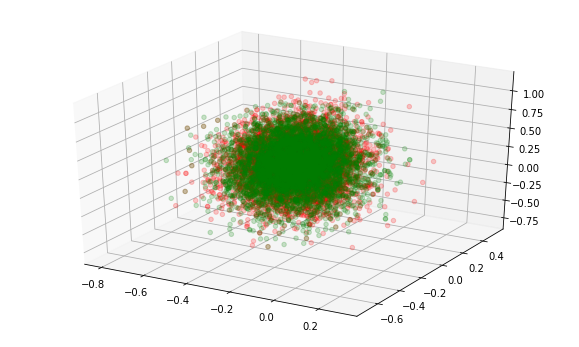

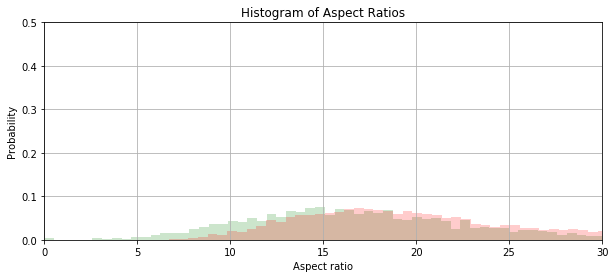

Mean negative distance 20.2154 mean positive distance 17.1993
Minibatch loss at step 1750 2695776.75
Minibatch accuracy: 61.328125 false positives: 53.0 false negatives: 46.0
Validation accuracy: 58.3303085299 false positives: 1361.0 false negatives: 935.0
(5510,)
(5510, 1)
(2582,)
(2928,)


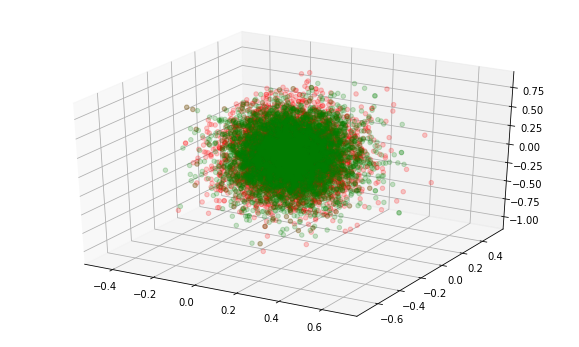

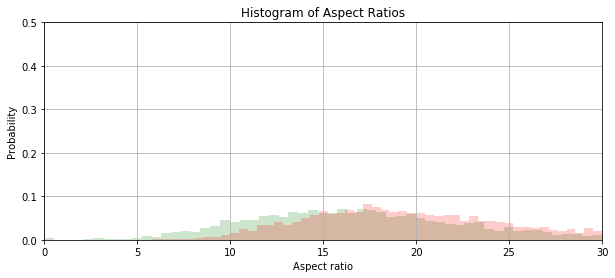

Mean negative distance 20.4706 mean positive distance 17.319
Minibatch loss at step 1800 2700792.25
Minibatch accuracy: 56.640625 false positives: 56.0 false negatives: 55.0
Validation accuracy: 60.5989110708 false positives: 1354.0 false negatives: 817.0
(5510,)
(5510, 1)
(2582,)
(2928,)


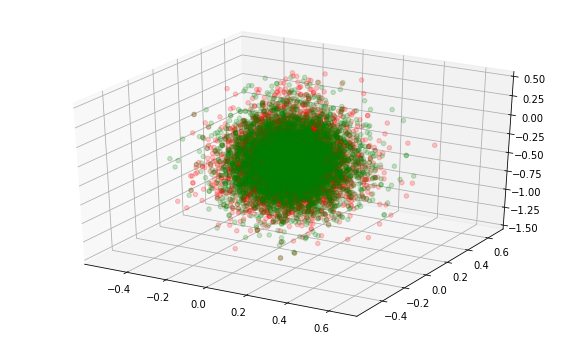

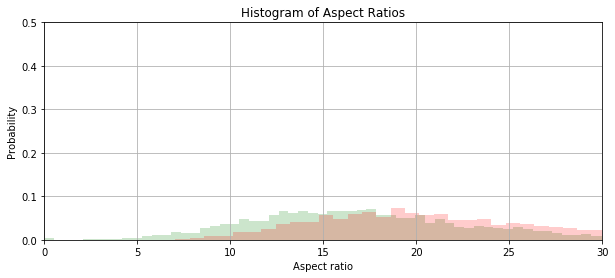

Mean negative distance 22.263 mean positive distance 17.7545
Minibatch loss at step 1850 2682335.25
Minibatch accuracy: 60.546875 false positives: 57.0 false negatives: 44.0
Validation accuracy: 59.5644283122 false positives: 1323.0 false negatives: 905.0
(5510,)
(5510, 1)
(2582,)
(2928,)


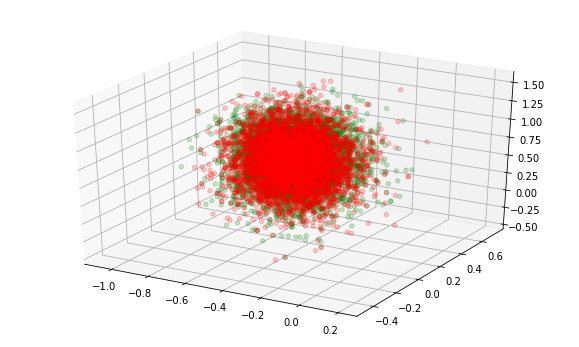

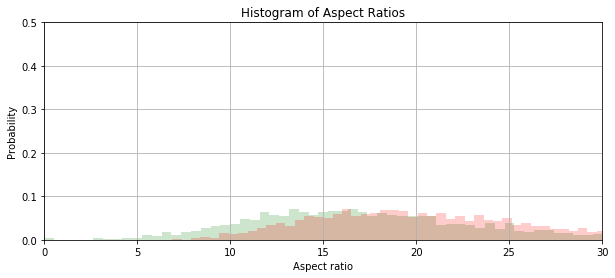

Mean negative distance 21.155 mean positive distance 17.4186
Minibatch loss at step 1900 2684098.25
Minibatch accuracy: 58.59375 false positives: 60.0 false negatives: 46.0
Validation accuracy: 58.5662431942 false positives: 1372.0 false negatives: 911.0
(5510,)
(5510, 1)
(2582,)
(2928,)


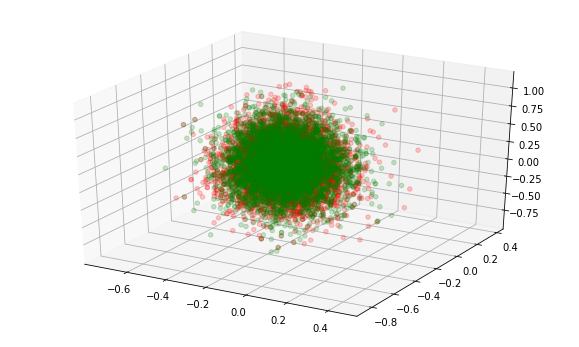

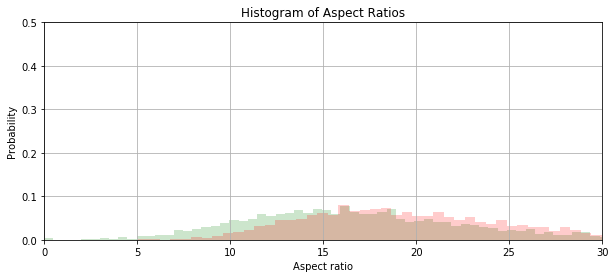

Mean negative distance 20.3187 mean positive distance 17.1533
Minibatch loss at step 1950 2672494.0
Minibatch accuracy: 57.03125 false positives: 66.0 false negatives: 44.0
Validation accuracy: 58.5662431942 false positives: 1369.0 false negatives: 914.0
(5510,)
(5510, 1)
(2582,)
(2928,)


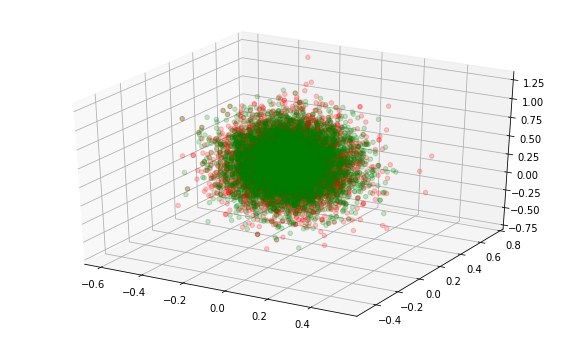

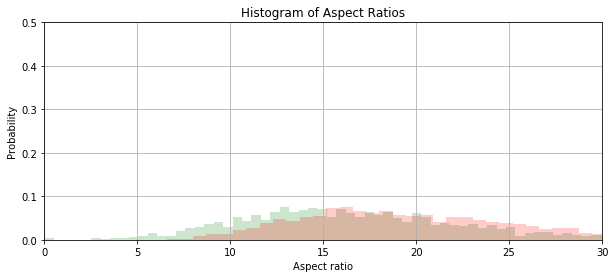

Mean negative distance 20.2749 mean positive distance 16.8892
Minibatch loss at step 2000 2671187.0
Minibatch accuracy: 56.25 false positives: 62.0 false negatives: 50.0
Validation accuracy: 59.6733212341 false positives: 1323.0 false negatives: 899.0
(5510,)
(5510, 1)
(2582,)
(2928,)


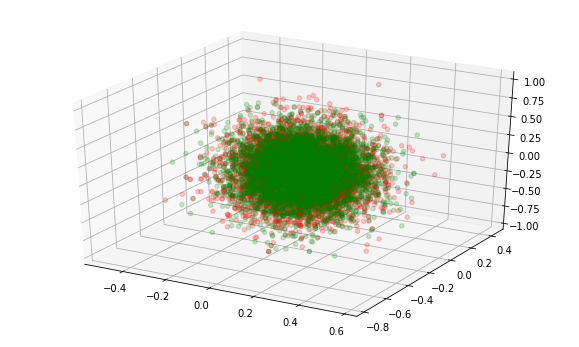

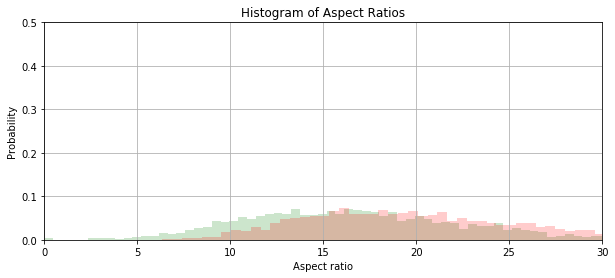

Mean negative distance 20.6181 mean positive distance 17.0649
Minibatch loss at step 2050 2667302.5
Minibatch accuracy: 61.328125 false positives: 61.0 false negatives: 38.0
Validation accuracy: 60.3811252269 false positives: 1315.0 false negatives: 868.0
(5510,)
(5510, 1)
(2582,)
(2928,)


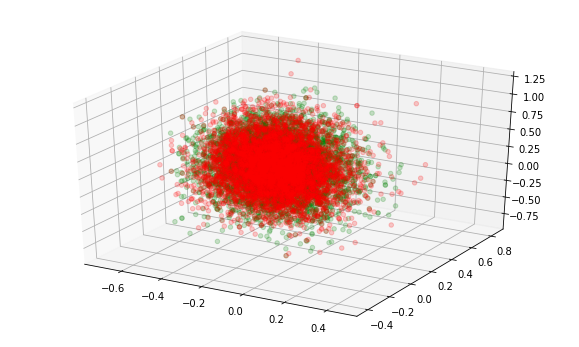

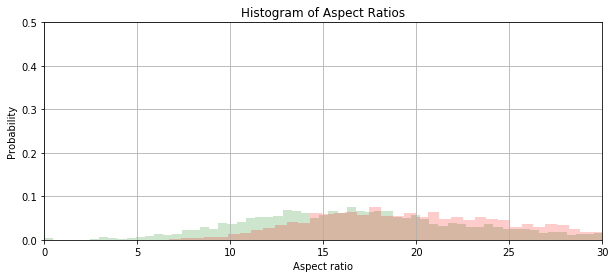

Mean negative distance 21.4053 mean positive distance 17.4336
Minibatch loss at step 2100 2668620.0
Minibatch accuracy: 55.859375 false positives: 57.0 false negatives: 56.0
Validation accuracy: 58.4210526316 false positives: 1342.0 false negatives: 949.0
(5510,)
(5510, 1)
(2582,)
(2928,)


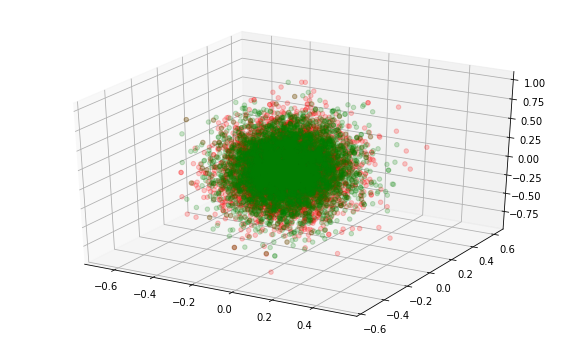

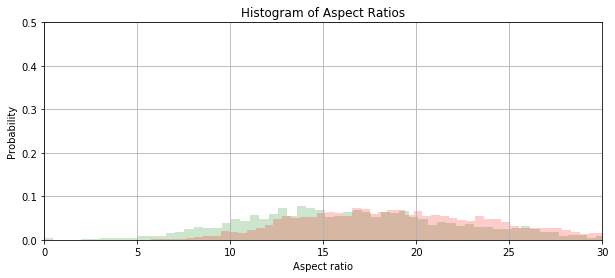

Mean negative distance 20.2484 mean positive distance 17.1357
Minibatch loss at step 2150 2653138.25
Minibatch accuracy: 65.234375 false positives: 50.0 false negatives: 39.0
Validation accuracy: 58.5480943739 false positives: 1355.0 false negatives: 929.0
(5510,)
(5510, 1)
(2582,)
(2928,)


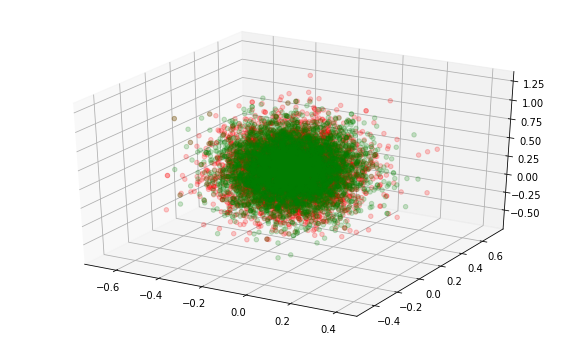

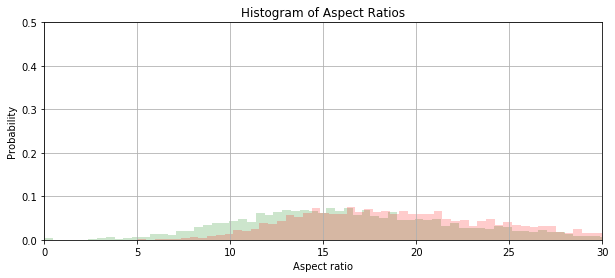

Mean negative distance 20.0921 mean positive distance 16.9678
Minibatch loss at step 2200 2651750.5
Minibatch accuracy: 59.765625 false positives: 55.0 false negatives: 48.0
Validation accuracy: 58.4029038113 false positives: 1364.0 false negatives: 928.0
(5510,)
(5510, 1)
(2582,)
(2928,)


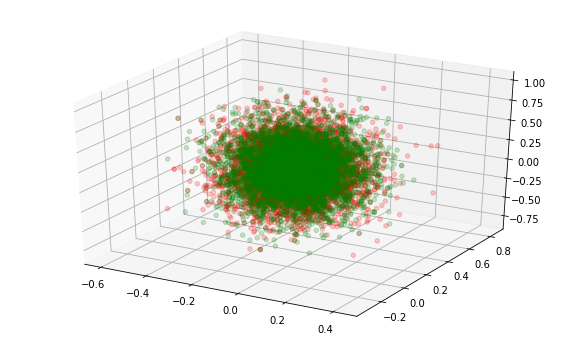

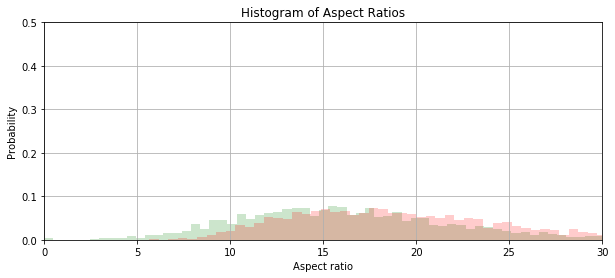

Mean negative distance 19.4673 mean positive distance 16.5736
Minibatch loss at step 2250 2657152.5
Minibatch accuracy: 66.015625 false positives: 66.0 false negatives: 21.0
Validation accuracy: 59.1833030853 false positives: 1355.0 false negatives: 894.0
(5510,)
(5510, 1)
(2582,)
(2928,)


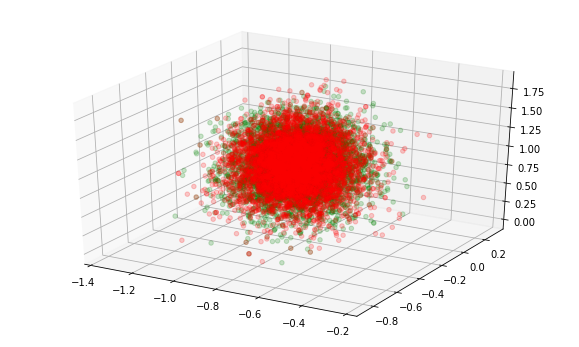

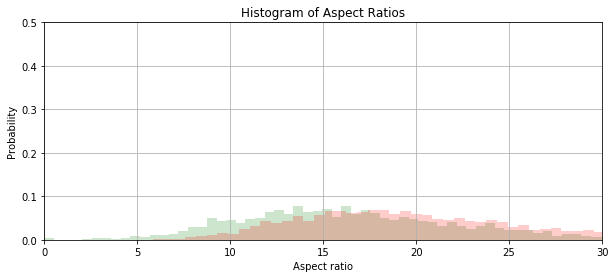

Mean negative distance 20.3531 mean positive distance 16.832
Minibatch loss at step 2300 2644459.0
Minibatch accuracy: 60.546875 false positives: 59.0 false negatives: 42.0
Validation accuracy: 59.9092558984 false positives: 1303.0 false negatives: 906.0
(5510,)
(5510, 1)
(2582,)
(2928,)


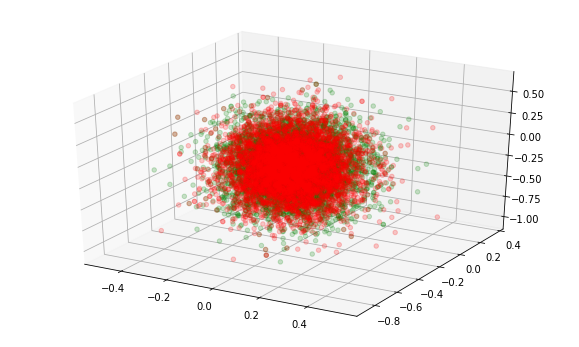

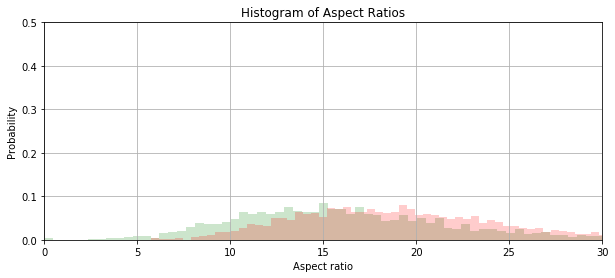

Mean negative distance 19.477 mean positive distance 16.3556
Minibatch loss at step 2350 2649438.5
Minibatch accuracy: 59.765625 false positives: 48.0 false negatives: 55.0
Validation accuracy: 58.7658802178 false positives: 1345.0 false negatives: 927.0
(5510,)
(5510, 1)
(2582,)
(2928,)


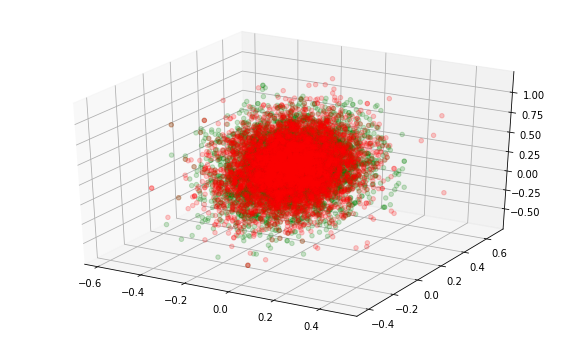

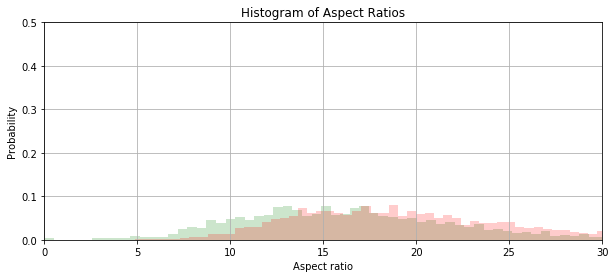

Mean negative distance 19.527 mean positive distance 16.6394
Minibatch loss at step 2400 2632235.0
Minibatch accuracy: 60.546875 false positives: 54.0 false negatives: 47.0
Validation accuracy: 59.1833030853 false positives: 1326.0 false negatives: 923.0
(5510,)
(5510, 1)
(2582,)
(2928,)


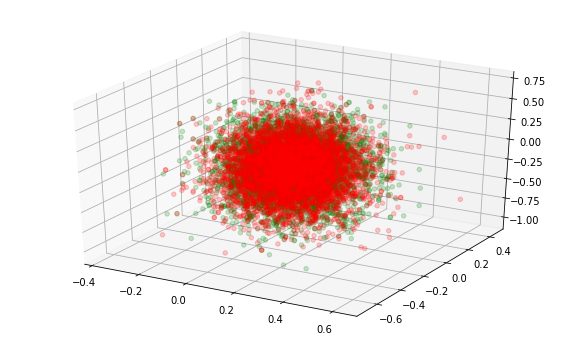

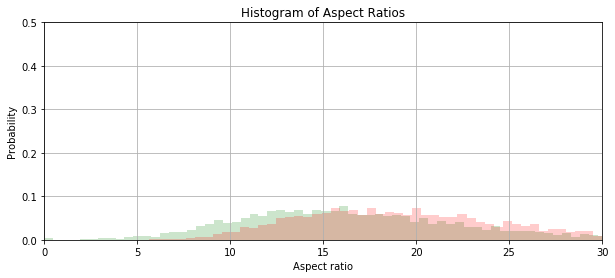

Mean negative distance 20.0344 mean positive distance 16.7691
Minibatch loss at step 2450 2639700.5
Minibatch accuracy: 54.296875 false positives: 53.0 false negatives: 64.0
Validation accuracy: 62.8493647913 false positives: 1391.0 false negatives: 656.0
(5510,)
(5510, 1)
(2582,)
(2928,)


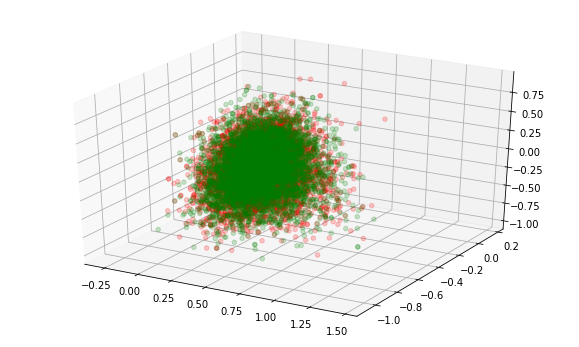

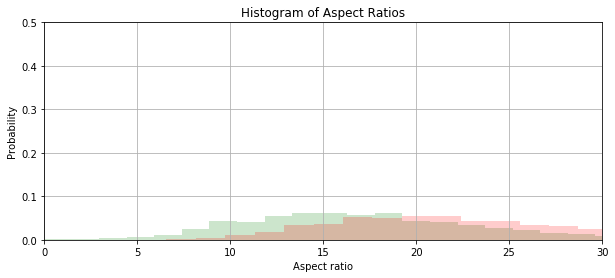

Mean negative distance 25.4508 mean positive distance 18.232
Minibatch loss at step 2500 2620839.5
Minibatch accuracy: 55.46875 false positives: 60.0 false negatives: 54.0
Validation accuracy: 60.3992740472 false positives: 1298.0 false negatives: 884.0
(5510,)
(5510, 1)
(2582,)
(2928,)


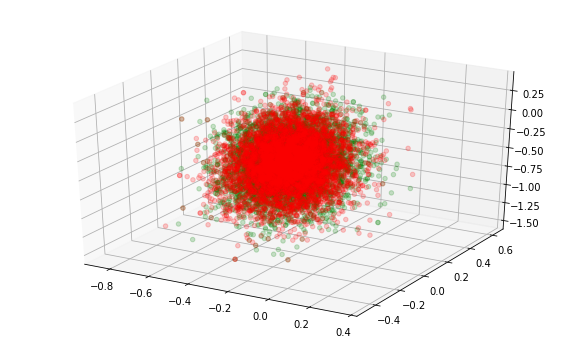

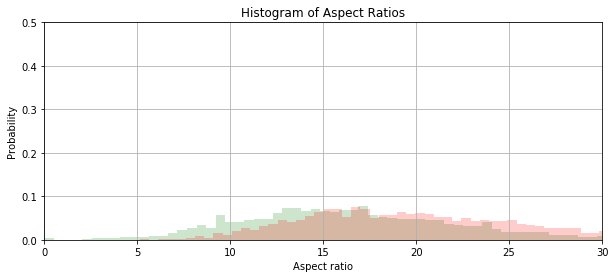

Mean negative distance 20.5011 mean positive distance 16.8533
Minibatch loss at step 2550 2613248.5
Minibatch accuracy: 58.203125 false positives: 67.0 false negatives: 40.0
Validation accuracy: 59.6007259528 false positives: 1326.0 false negatives: 900.0
(5510,)
(5510, 1)
(2582,)
(2928,)


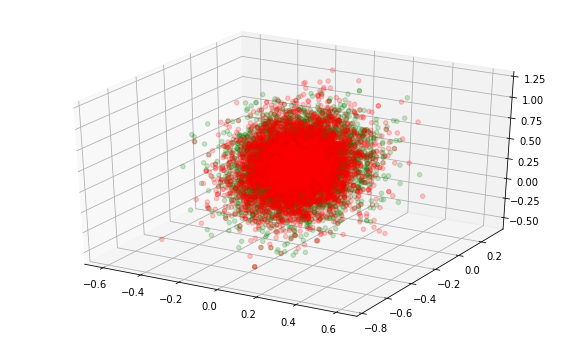

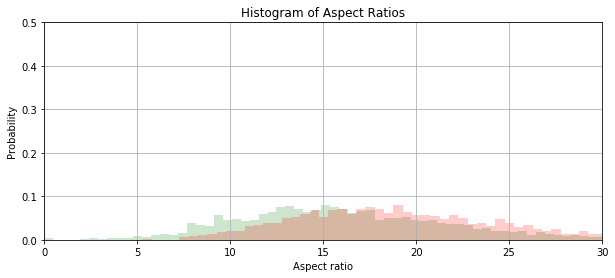

Mean negative distance 19.5976 mean positive distance 16.3964
Minibatch loss at step 2600 2598552.25
Minibatch accuracy: 60.546875 false positives: 61.0 false negatives: 40.0
Validation accuracy: 59.3829401089 false positives: 1316.0 false negatives: 922.0
(5510,)
(5510, 1)
(2582,)
(2928,)


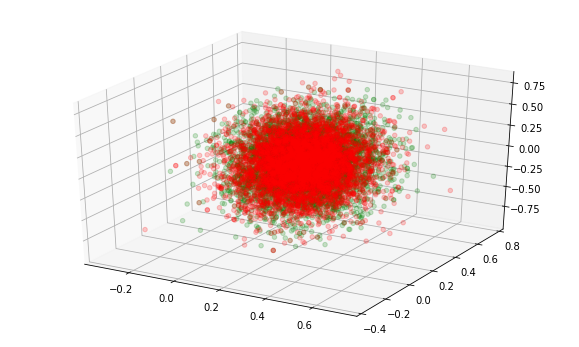

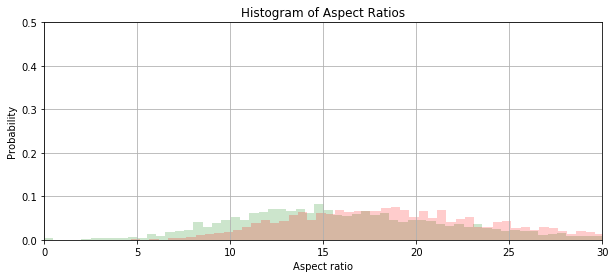

Mean negative distance 19.6155 mean positive distance 16.4713
Minibatch loss at step 2650 2607877.75
Minibatch accuracy: 53.90625 false positives: 64.0 false negatives: 54.0
Validation accuracy: 59.8548094374 false positives: 1327.0 false negatives: 885.0
(5510,)
(5510, 1)
(2582,)
(2928,)


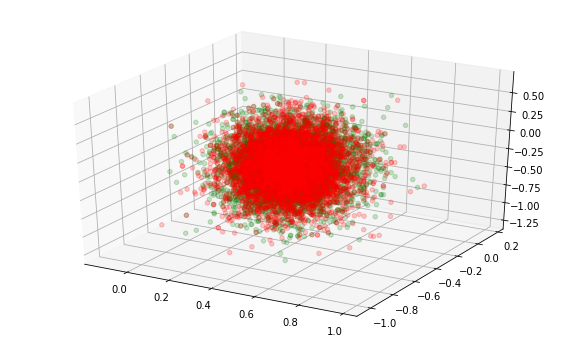

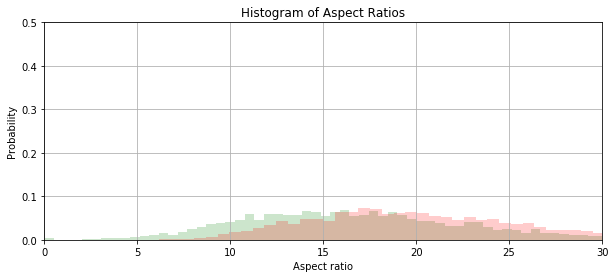

Mean negative distance 20.9868 mean positive distance 17.2819
Minibatch loss at step 2700 2607535.0
Minibatch accuracy: 58.203125 false positives: 57.0 false negatives: 50.0
Validation accuracy: 58.6206896552 false positives: 1343.0 false negatives: 937.0
(5510,)
(5510, 1)
(2582,)
(2928,)


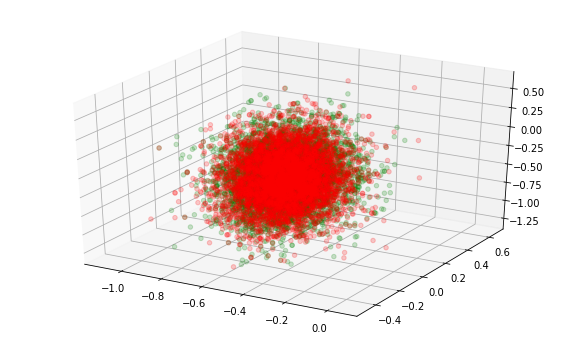

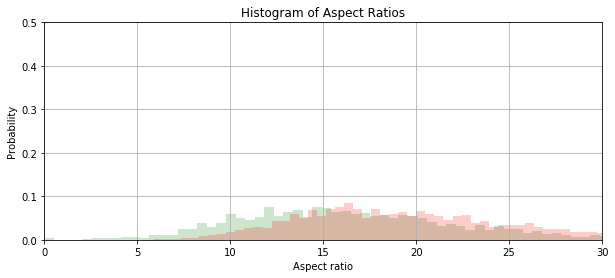

Mean negative distance 19.8649 mean positive distance 16.7093
Minibatch loss at step 2750 2597702.75
Minibatch accuracy: 53.515625 false positives: 59.0 false negatives: 60.0
Validation accuracy: 58.8021778584 false positives: 1344.0 false negatives: 926.0
(5510,)
(5510, 1)
(2582,)
(2928,)


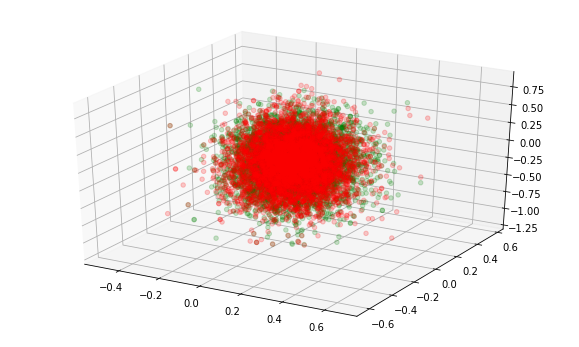

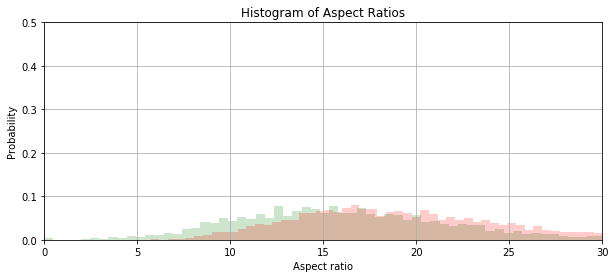

Mean negative distance 19.6681 mean positive distance 16.5633
Minibatch loss at step 2800 2589765.75
Minibatch accuracy: 53.515625 false positives: 65.0 false negatives: 54.0
Validation accuracy: 58.1488203267 false positives: 1368.0 false negatives: 938.0
(5510,)
(5510, 1)
(2582,)
(2928,)


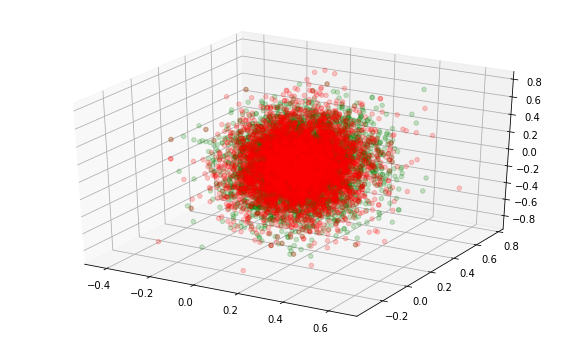

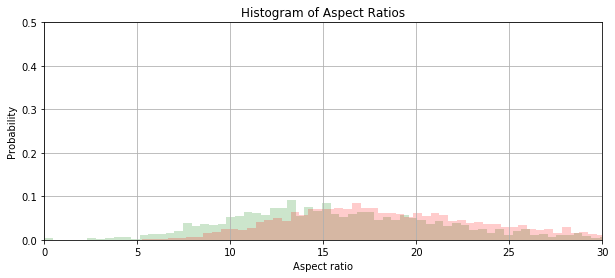

Mean negative distance 19.0369 mean positive distance 16.1501
Minibatch loss at step 2850 2585018.25
Minibatch accuracy: 55.46875 false positives: 62.0 false negatives: 52.0
Validation accuracy: 57.8947368421 false positives: 1364.0 false negatives: 956.0
(5510,)
(5510, 1)
(2582,)
(2928,)


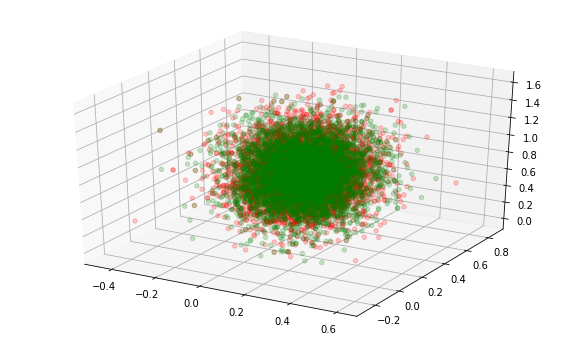

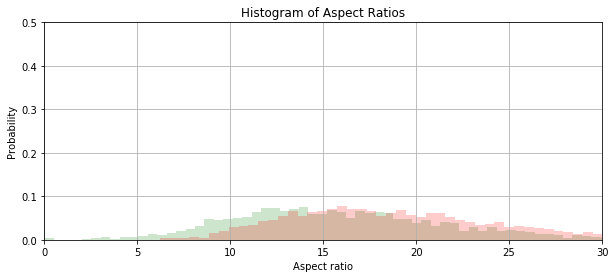

Mean negative distance 19.0615 mean positive distance 16.2425
Minibatch loss at step 2900 2579044.25
Minibatch accuracy: 53.515625 false positives: 69.0 false negatives: 50.0
Validation accuracy: 58.3847549909 false positives: 1343.0 false negatives: 950.0
(5510,)
(5510, 1)
(2582,)
(2928,)


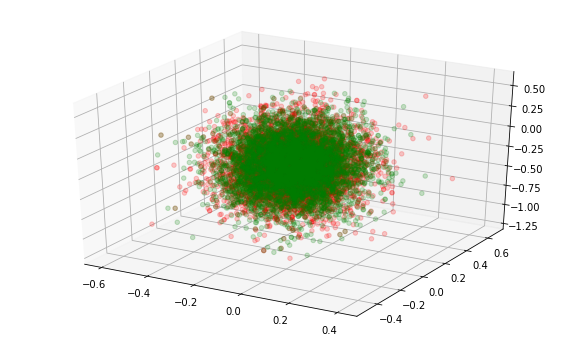

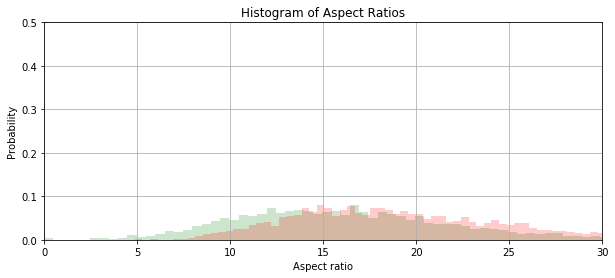

Mean negative distance 19.4425 mean positive distance 16.4206
Minibatch loss at step 2950 2566135.5
Minibatch accuracy: 59.765625 false positives: 63.0 false negatives: 40.0
Validation accuracy: 60.2359346642 false positives: 1310.0 false negatives: 881.0
(5510,)
(5510, 1)
(2582,)
(2928,)


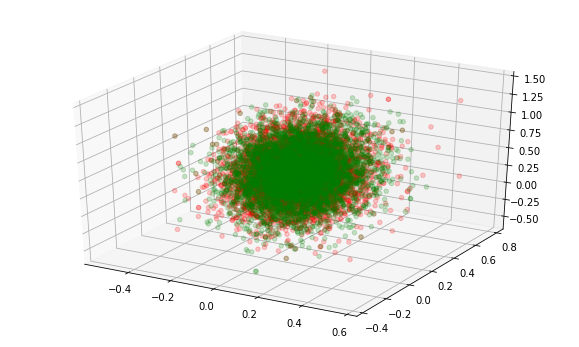

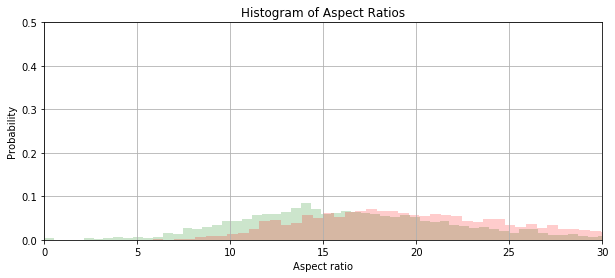

Mean negative distance 20.7131 mean positive distance 16.9774
Minibatch loss at step 3000 2570748.5
Minibatch accuracy: 57.03125 false positives: 60.0 false negatives: 50.0
Validation accuracy: 58.6932849365 false positives: 1346.0 false negatives: 930.0
(5510,)
(5510, 1)
(2582,)
(2928,)


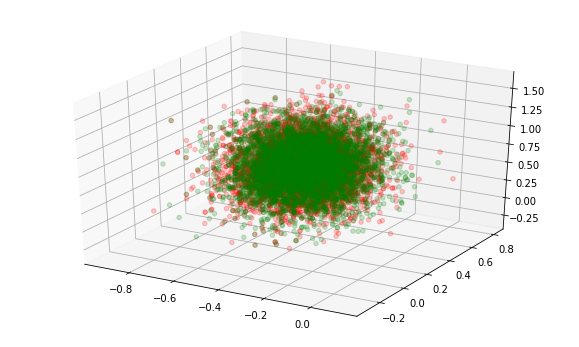

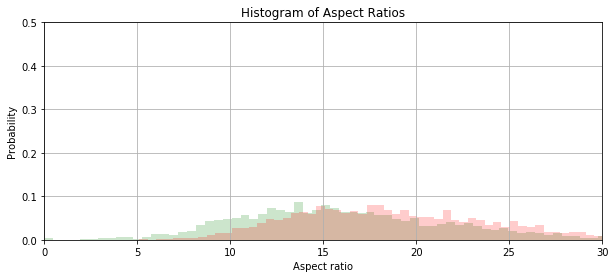

Mean negative distance 19.2941 mean positive distance 16.4145


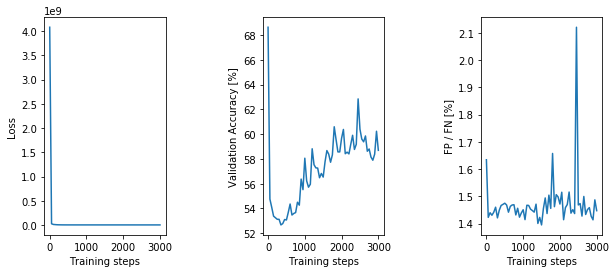

In [13]:
#Plots
P_FREQ = 50
losses = []
accuracies = []
rates = []

with tf.Session(graph=siamese_model) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  for step in range(NUM_STEPS):
    offset = (step * BATCH_SIZE) % (train_labels.shape[0] - BATCH_SIZE)
    batch_data_X1 = train_X1_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_data_X2 = train_X2_dataset[offset:(offset + BATCH_SIZE), :, :, :]
    batch_labels = train_labels[offset:(offset + BATCH_SIZE), :]
    feed_dict = {tf_train_X1_dataset : batch_data_X1, tf_train_X2_dataset : batch_data_X2, \
                 tf_train_labels : batch_labels}
    _, _loss, predictions = session.run(
      [optimizer, loss, train_prediction], feed_dict=feed_dict)
    
    if np.isnan(_loss):
        print('Model diverged with loss = NaN')
        quit()
        
    #Plot variables
    if (step % P_FREQ == 0):
      losses.append(_loss)
      distances = valid_prediction.eval()
      acc, fp, fn = accuracy(distances, valid_labels)
      accuracies.append(acc)
      rates.append(float(fp/fn))
      embeddings1 = embedding1.eval()
      embeddings2 = embedding2.eval()
      fig = plt.figure(figsize=(10, 6))
      ax = fig.add_subplot(111, projection='3d')
      ax.scatter(embeddings1[:,0], embeddings1[:,1], embeddings1[:,2], zdir='z', s=20, c=None, depthshade=True,facecolor='green', alpha=0.2)
      ax.scatter(embeddings2[:,0], embeddings2[:,1], embeddings2[:,2], zdir='z', s=20, c=None, depthshade=True,facecolor='red', alpha=0.2)
    
    if (step % 50 == 0):
      print('Minibatch loss at step {} {}'.format(step, _loss))
      a = accuracy(predictions, batch_labels)
      print('Minibatch accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      a = accuracy(valid_prediction.eval(), valid_labels)
      print('Validation accuracy: {} false positives: {} false negatives: {}'.format(a[0], a[1], a[2] ) )
      print_means(valid_prediction.eval(), valid_labels)
#print('Test accuracy: %.1f%%' % accuracy(test_prediction.eval(), test_labels))

# Show the results.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
plt.subplots_adjust(wspace=.8)
fig.set_size_inches(10, 4)
ax1.plot(range(0, NUM_STEPS, P_FREQ), losses)
ax1.set_ylabel("Loss")
ax1.set_xlabel("Training steps")
ax2.plot(range(0, NUM_STEPS, P_FREQ), accuracies)
ax2.set_ylabel("Validation Accuracy [%]")
ax2.set_xlabel("Training steps")
ax3.plot(range(0, NUM_STEPS, P_FREQ), rates)
ax3.set_ylabel("FP / FN [%]")
ax3.set_xlabel("Training steps")
plt.show()


In [ ]:
def accuracy_dbg(predictions, labels, print_nr = 0):
    aux = predictions < MARGIN
    equal = np.equal(aux[:] , labels[:,0])
    print(predictions[print_nr])
    print(labels[print_nr])
    print(aux[print_nr].astype(np.float32))
    print(aux.shape)
    print(labels.shape)
    print(equal.shape)
    print(predictions.shape)
    acc = (100.0 * np.sum(equal.astype(np.float32))
          / predictions.shape[0])
    false_pos = 12
    false_neg = 122
    return acc, false_pos, false_neg
a = accuracy_dbg(hey, valid_labels, 24)
print(a)
print(" {} {} {}".format(a[0], a[1], a[2]))

In [ ]:
a = np.array([0, 1, 1, 1, 1, 0, 0, 0])
b = np.where(a == 0)
c = a[b]
print(c)

In [ ]:
a = np.ones([10,2]) * 2
b = np.ones([10,2]) * 3
print (a)
print(b)

c = a *b
 
print(c)